[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slahiri/LendingClubCaseStudy/blob/master/Siddhartha_Lahiri.ipynb)

# Lending Club Case Study

## Table of Content

1. [Problem Statement](#Problem-Statement)
2. [Objectives](#Objectives)
3. [Data Understanding](#Data-Understanding) 
    1. [Data Understanding Domain](#Data-Understanding-Domain)
    2. [Data Understanding EDA](#Data-Understanding-EDA)
    3. [Columns Analysis](#Columns-Analysis)
    4. [Missing Data Rules](#Missing-Data-Rules)
    5. [Column Dropping Rules](#Column-Dropping-Rules)
    6. [Outlier Treatment Rules](#Outlier-Treatment-Rules)
4. [Loading Data](#Loading-Data)
5. [Data Cleaning and Manipulation](#Data-Cleaning-and-Manipulation)
    1. [Columns Review](#Columns-Review)
    2. [Data Dictionary Review](#Data-Dictionary-Review)
    3. [Dropping Rows](#Dropping-Rows)
    4. [Dropping Columns](#Dropping-Columns)
    5. [Data Conversion](#Data-Conversion)
    6. [Imputing vs Dropping Columns](#Imputing-vs-Dropping-Columns)
    7. [Derived Columns](#Derived-Columns)
    8. [Data Analysis Post Cleanup](#Data-Analysis-Post-Cleanup)
6. [Univeriate Analysis](#Univeriate-Analysis)
    1. [Common Functions](#Common-Functions)
    2. [Outlier Treatment](#Outlier-Treatment)
    3. [Quantitative Variable Analysis](#Quantitative-Variable-Analysis)
    4. [Unordered Categorical Variable Analysis](#Unordered-Categorical-Variable-Analysis)
    5. [Ordered Categorical Variable Analysis](#Ordered-Categorical-Variable-Analysis)
    6. [Derived Variable Analysis](#Derived-Variable-Analysis)
    7. [Univariate Analysis Summary](#Univariate-Analysis-Summary)
7. [Bivariate Analysis](#Bivariate-Analysis)
    1. [Analysis vs Charged Off Status](#Analysis-vs-Charged-Off-Status)
    2. [Correlation Analysis](#Correlation-Analysis)
    3. [Bivariate Analysis Summary](#Bivariate-Analysis-Summary)
8. [Summary](#Summary)

## Problem Statement

Lending Club is a consumer finance marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return.

It specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant's profile.

Like most other lending companies, *lending loans to ‘risky’* applicants is the largest source of financial loss *(called credit loss)*. The credit loss is the amount of money lost by the lender when the borrower refuses to pay or runs away with the money owed.

In other words, **borrowers** who **default** cause the largest amount of **loss to the lenders**. In this case, the customers labelled as *'charged-off' are the 'defaulters'*.

The core objective of the excercise is to **help the company minimise the credit loss**. There are two potential sources of **credit loss** are:
* Applicant **likely to repay the loan**, such an applicant will bring in profit to the company with interest rates.** Rejecting such applicants will result in loss of business**.
* Applicant **not likely to repay** the loan, i.e. and will potentially default, then approving the loan may lead to a financial loss* for the company

## Objectives
The goal is to *identify these risky loan applicants*, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA using the given [dataset](./data/loan.csv), is the aim of this case study.

If one is able to *identify these risky loan applicants*, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.

In other words, **the company wants to understand the driving factors (or driver variables)** behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment. 

## Data Understanding

The data given below contains the information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

- The dataset reflects loans post approval, thus does not represent any information on the rejection criteria process
    - Overall objective will be to observe key leading indicaters (driver variables) in the dataset, which contribute to defaulters
    - Use the analysis as a the foundation of the hypothesis
- The overall loan process is represented by three steps
    - Potential borrower requests for loan amount (loan_amnt)
    - The approver approves/rejects an amount based on past history/risk (funded_amnt)
    - The final amount offered as loan by the investor (funded_amnt_inv)

### Data Understanding Domain

#### Leading Attribute
- *Loan Status* - Key Leading Attribute (*loan_status*). The column has three distinct values
    - Fully-Paid - The customer has successfuly paid the loan
    - Charged-Off - The customer is "Charged-Off" ir has "Defaulted"
    - Current - These customers, the loan is currently in progress and cannot contribute to conclusive evidence if the customer will default of pay in future
        - For the given case study, "Current" status rows will be ignored

#### Decision Matrix
* *Loan Accepted* - Three Scenarios
    * *Fully Paid* -  Applicant has fully paid the loan (the principal and the interest rate)
    * *Current* - Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.
    * *Charged-off* - Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has *defaulted* on the loan 
* *Loan Rejected* - The company had rejected the loan (because the candidate does not meet their requirements etc.). Since the loan was rejected, there is no transactional history of those applicants with the company and so this data is not available with the company (and thus in this dataset)

#### Important Columns
The given columns are leading attributes, or **predictors**. These attributes are available at the time of the loan application and strongly helps in **prediction** of loan pass or rejection. Key attributes *Some of these columns may get dropped due to empty data in the dataset*
* **Customer Demographics**
  * Annual Income (annual_inc) - Annual income of the customer. Generally higher the income, more chances of loan pass
  * Home Ownership (home_ownership) - Wether the customer owns a home or stays rented. Owning a home adds a collateral which increases the chances of loan pass.
  * Employment Length (emp_length) - Employment tenure of a customer (this is overall tenure). Higher the tenure, more financial stablity, thus higher chances of loan pass
  * Debt to Income (dti) - The percentage of the salary which goes towards paying loan. Lower DTI, higher the chances of a loan pass.
  * State (addr_state) - Location of the customer. Can be used to create a generic demographic analysis. There could be higher delinquency or defaulters demographicaly. 
* **Loan Attributes**
  * Loan Ammount (loan_amt) 
  * Grade (grade)
  * Term (term)
  * Loan Date (issue_date)
  * Purpose of Loan (purpose)
  * Verification Status (verification_status)
  * Interest Rate (int_rate)
  * Installment (installment)
  * Public Records (public_rec) - Derogatory Public Records. The value adds to the risk to the loan. Higher the value, lower the success rate.
  * Public Records Bankruptcy  (public_rec_bankruptcy) - Number of bankruptcy records publocally available for the customer. Higher the value, lower is the success rate.
  

#### Ignored Columns
* The following types of columns will be ignored in the analysis. This is a generic categorization of the columns which will be ignored in our approach and not the full list.
   * **Customer Behaviour Columns** - Columns which describes customer behaviour will not contribute to the analysis. The current analysis is at the time of loan application but the customer behaviour variables generate post the approval of loan applications. Thus these attributes wil not be considered towards the loan approval/rejection process.
   * Granular Data - Columns which describe next level of details which may not be required for the analysis. For example grade may be relevant for creating business outcomes and visualizations, sub grade is be very granular and will not be used in the analysis

### Data Understanding EDA


#### Rows Analysis
- Summary Rows: No summary rows were there in the dataset
- Header & Footer Rows - No header or footer rows in the dataset
- Extra Rows - No column number, indicators etc. found in the dataset
- Rows where the **loan_status = CURRENT will be dropped** as CURRENT loans are in progress and will not contribute in the decision making of pass or fail of the loan. The rows are dropped before the column analysis as it also cleans up unecessary column related to CURRENT early and columns with NA values can be cleaned in one go
- Find duplicate rows in the dataset and drop if there are

### Columns Analysis

#### Drop Columns 
- There are multiple columns with **NA values** only. The **columns will be dropped**. 
    - *This is evaluated after dropping rows with `loan_status = Current`*
    - `(next_pymnt_d, mths_since_last_major_derog, annual_inc_joint, dti_joint, verification_status_joint, tot_coll_amt, tot_cur_bal, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, total_rev_hi_lim, inq_fi, total_cu_tl, inq_last_12m, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy, bc_util, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, mths_since_recent_bc_dlq, mths_since_recent_inq, mths_since_recent_revol_delinq, num_accts_ever_120_pd, num_actv_bc_tl, num_actv_rev_tl, num_bc_sats, num_bc_tl, num_il_tl, num_op_rev_tl, num_rev_accts, num_rev_tl_bal_gt_0, num_sats, num_tl_120dpd_2m, num_tl_30dpd, num_tl_90g_dpd_24m, num_tl_op_past_12m, pct_tl_nvr_dlq, percent_bc_gt_75, tot_hi_cred_lim, total_bal_ex_mort, total_bc_limit, total_il_high_credit_limit)`
- There are multiple columns where the **values are only zero**, the **columns will be dropped**
- There are columns where the **values are constant**. They dont contribute to the analysis, **columns will be dropped**
- There are columns where the **value is constant but the other values are NA**. The column will be considered as constant. **columns will be dropped**
- There are columns where **more than 65% of data is empty** `(mths_since_last_delinq, mths_since_last_record)` - **columns will be dropped**
- **Drop columns `(id, member_id)`** as they are **index variables and have unique values** and dont contribute to the analysis
- **Drop columns `(emp_title, desc, title)`** as they are **discriptive and text (nouns) and dont contribute to analysis**
- **Drop redundant columns `(url)`**. On closer analysis url is a static path with the loan id appended as query. It's a redundant column to `(id)` column
- **Drop customer behaviour columns which represent data post the approval of loan** 
    - They contribute to the behaviour of the customer. Behaviour of the customer is recorded post approval of loan and not available at the time of loan approval. Thus these variables will not be considered in analysis and thus dropped
    - `(delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, application_type)`
    
#### Convert Column Format
- `(loan_amnt, funded_amnt, funded_amnt_inv)` columns are Object and will be converted to float
- `(int_rate, installment, dti)` columns are Object and will be converted to float
- **strip "month"** text from `term` column and convert to integer
- Percentage columns `(int_rate)` are object. **Strip "%"** characters and convert column to float
- `issue_d` column **converted to datetime format**

#### Standardise Values
- All currency columns are rounded off to 2 decimal places as currency are limited to cents/paise etc only.

#### Convert Column Values
- `loan_status` column converted to boolean **Charged Off = False and Fully Paid = True**. This converts the column into ordinal values
- `emp_length` converted to integer with following logic. Note < 1 year is converted to zero and 10+ converted to 10.
    - < 1 year: 0,  
    - 2 years: 2,  
    - 3 years: 3,  
    - 7 years: 7,  
    - 4 years: 4,
    - 5 years: 5,
    - 1 year: 1,
    - 6 years: 6,
    - 8 years: 8,
    - 9 years: 9,
    - 10+ years: 10

#### Added new columns
- verification_status_n added. Considering domain knowledge of lending = Verified > Source Verified > Not Verified. verification_status_n correspond to {Verified: 3, Source Verified: 2. Not Verified: 1} for better analysis
- issue_y is year extracted from issue_d
- issue_m is month extracted from issue_d



### Missing Data Rules
*  Columns with high percentage of missing values will be dropped **(65% above for this case study)**
*  Columns with less percentage of missing value will be imputed
*  Rows with high percentage of missing values will be removed **(65% above for this case study)**

### Column Dropping Rules
- Approach taken here in this analysis, if total number of rows (for all columns) which are blank is less than 5% of the dataset, we are dropping the rows. If the total rows are greater than 5% we will impute
- If the dataset of blanks is considerably small, dropping the rows will possible be more accurate approach withoug impacting the dataset and the outcomes
- If the dataset of blanks are considerably large, dropping the rows will skew the analysis and impute approach will be taken
- In the current dataset, combined row count of blanks for `emp_length` and `pub_rec_bankruptcies` is 1730, which is 4.48% of the total rows thus dropping the rows will be the more accurate approach
- If imputing, we will correlate `emp_length` with `annual_inc`, with the logic that higher the length of employment, higher the salary potentially. With this approach, the outliers can potentially introduce noise.

### Outlier Treatment Rules
- Approach taken in this analysis to drop all outlier rows
- The following columns were evaluated for outliers `loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti`
- Total rows dropped due to outlier treatment:  3791
- Percentage of rows dropped due to outlier treatment:  10.29 %

## Loading Data

### Imports and Initial Setup

In [975]:
# Importing core libraries required for the case study
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sea
import datetime as dt
import warnings

# Setting max rows settings to 200 to display all the summary data
pd.set_option("display.max_rows", 50)

# Suppress warnings
warnings.filterwarnings('ignore')

### Load data from CSV

To make the program work, checkout the GitHub repo using the command:
```shell
git clone https://github.com/slahiri/LendingClubCaseStudy.git
```
Create a folder in the checked out location, here inside "LendingClubCaseStudy" folder and copy the loan.csv
```shell
mkdir data
cp /source_location/loan.csv /dest_location/LendingClubCaseStudy/data
```
Set the variable names ```data_folder``` and ```loan_csv``` corresponding to the folder name created and name of loan file below:


In [976]:
# Loading the loan raw dataset
data_folder = ".data"
loan_csv = "loan.csv"

# The "loan" variable represents the dataframe loaded from the CSV
loan = pd.read_csv('./' + data_folder + '/' + loan_csv, low_memory=False)
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Data Cleaning and Manipulation

### Columns Review

In [977]:
# Print summary of Nulls, Blanks in the dataset
(loan.isnull().sum()/len(loan.index) * 100)

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
                                 ...    
tax_liens                       0.098195
tot_hi_cred_lim               100.000000
total_bal_ex_mort             100.000000
total_bc_limit                100.000000
total_il_high_credit_limit    100.000000
Length: 111, dtype: float64

### Data Dictionary Review

In [978]:
# Loading all data dictionary values
dict = pd.read_excel('Data_Dictionary.xlsx')
dict

,LoanStatNew,Description,Column Status,Reason,Type Analysis
0,acc_now_delinq,The number of accounts on which the borrower i...,Dropped,Zero Value,NaN
1,acc_open_past_24mths,Number of trades opened in past 24 months.,Dropped,NA Values,NaN
2,addr_state,The state provided by the borrower in the loan...,Retained,NaN,Unordered Categorical Variable
3,all_util,Balance to credit limit on all trades,Dropped,NA Values,NaN
4,annual_inc,The self-reported annual income provided by th...,Retained,Important Attribute,NaN
...,...,...,...,...,...
112,verification_status,"Indicates if income was verified by LC, not ve...",Retained,Important Attribute,Unordered Categorical Variable
113,verification_status_joint,Indicates if the co-borrowers' joint income wa...,Dropped,NA Values,NaN
114,zip_code,The first 3 numbers of the zip code provided b...,Retained,NaN,Unordered Categorical Variable
115,NaN,NaN,NaN,NaN,NaN


### Dropping Rows 

#### where loan_status = "Current"

In [979]:
prev_rows = len(loan)

# The rows where loan_stats=Current are the data where the loan repayment is currently in progress
# The loans which are currently in progress will not contribute to decisions 
# of default or pass as it's difficult to predict the outcome
#
# Dropping the rwos early as, dropping all Currrent rows introduces NA columns which can be easily dropped
loan = loan[loan['loan_status'] != "Current"]

In [980]:
# Print current data statistics after dropping rows with loan_status "CURRENT"
curr_rows = len(loan)

print("Number of rows dropped where loan_status = 'Current':", (prev_rows - curr_rows))
print("Percentage of rows dropped = ", round((prev_rows - curr_rows)/prev_rows*100,2),"%")

Number of rows dropped where loan_status = 'Current': 1140
Percentage of rows dropped =  2.87 %


In [981]:
# Find any duplicate rows in the dataset
duplicate_rows = len(loan[loan.duplicated()])
if duplicate_rows <= 0:
    print("Duplicate Rows: ", duplicate_rows)
    print("No action needed")
else:
    print("Do something")

Duplicate Rows:  0
No action needed


### Dropping Columns

In [982]:
# Dropping columns which is unique id in nature. They dont contribute to loan analysis

# Checking if member_id is unique
if len(loan['member_id'].unique()) == loan.shape[0]:
    print("member_id is unique, can be dropped")
    loan = loan.drop(['member_id'],  axis=1)
else:
    print("member_id is not unique, dont drop")

# Checking if id is unique
if len(loan['id'].unique()) == loan.shape[0]:
    print("id is unique, can be dropped")
    # not dropping id as it will be used for pivot calculation later
    # loan = loan.drop(['id'],  axis=1)
else:
    print("id is not unique, dont drop")

member_id is unique, can be dropped
id is unique, can be dropped


In [983]:
# Dropping text/description columns which wont contribute to overall analysis
# These are names of establishment etc which will not contribute to loan pass or failure
# THe URL column is a static link with id as the attribute. Its a redundant column
loan = loan.drop(['url', 'emp_title', 'desc', 'title'],  axis=1)

# Dropping column sub_grade as the current analysis will limit to Grade only
loan = loan.drop(['sub_grade'],  axis=1)

In [984]:
# Dropping all columns which refer to behavoural data of customer post loan approval 
# Behaviour data of the customers are captured post the loan approval
# The data is not available at the time of loan approval and thus cannot be used for calculations
loan = loan.drop(['delinq_2yrs', 'earliest_cr_line', 
                          'inq_last_6mths', 'open_acc', 'pub_rec', 
                          'revol_bal', 'revol_util', 'total_acc', 
                          'out_prncp', 'out_prncp_inv', 'total_pymnt', 
                          'total_pymnt_inv', 'total_rec_prncp', 
                          'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                          'collection_recovery_fee', 'last_pymnt_d', 
                          'last_pymnt_amnt', 'last_credit_pull_d', 
                          'application_type'],  axis=1)

In [985]:
# Dropping all columns whose all the values are NA
# Print all NA columns for verification
print("Total columns with values NA: ", len(loan.columns[loan.isna().all()].tolist()),"\n\n")
print("Columns with all values as NA\n", loan.columns[loan.isna().all()].tolist())

# Dropping all the columns whose all the records are NaN or Null
loan = loan.dropna(axis='columns', how="all")

Total columns with values NA:  55 


Columns with all values as NA
 ['next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_7

In [986]:
# Dropping all columns with all zero values
loan = loan.loc[:, (loan != 0).any(axis=0)]

In [987]:
# Function to Drop all columns who have constant values (ignoring NA value)
# Example most of the columns is 1 and rest is NA, the column will be dropped
# If we have 1,2 and NA, the column wont be dropped
print("Columns with constant values with or without NA")
def drop_constant_columns(df):
    for c in df.columns:
        if df[c].nunique(dropna=True) == 1:
            print(c)
            df = df.drop(c, axis=1)
    return df

# Drop all constant columns from df1 (definition of constant is constant value across the rows, this ignores Na values)
loan = drop_constant_columns(loan)

Columns with constant values with or without NA
pymnt_plan
initial_list_status
collections_12_mths_ex_med
policy_code
chargeoff_within_12_mths
tax_liens


In [988]:
# Function which checks the amount of empty values in a dataframe and 
# drops the column if the amount of empty values is more than 65%
# 60% is the threshhold percentage which decides imputing vs dropping 
print("Columns with more that 65% empty records")
def drop_mostly_empty_columns(df):
    total_rows = len(df)
    for c in df.columns:
        # Drop columns whose mean na values exceed 65%
        if df[c].isna().mean().round(2) >= 0.65:
            print(c)
            df = df.drop(c, axis=1)
    return df
loan = drop_mostly_empty_columns(loan)

Columns with more that 65% empty records
mths_since_last_delinq
mths_since_last_record


### Data Conversion

In [989]:
# Convert the columns loan_amnt and funded_amnt as flot64
loan = loan.astype({'loan_amnt':'float','funded_amnt':'float'})

In [990]:
# Convert the term column into an integer from a string
loan['term'] = loan['term'].apply(lambda x : int(x[:-7]))

In [991]:
# Convert int_rate to  float by removing the "%" character
loan['int_rate'] = loan['int_rate'].apply(lambda x : float(x[:-1]))

In [992]:
# Round off the values of key float fields to 2 decimal place
# all int_rate and dti already limited to 2 edcimal
print("Rounding columns to 2 decimal places")
for c in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'dti']:
    print(c)
    loan[c] = loan[c].apply(lambda x: round(x,2))

Rounding columns to 2 decimal places
loan_amnt
funded_amnt
funded_amnt_inv
int_rate
dti


In [993]:
# Converting the loan_status to boolean column. "Fully-Paid is True and Charged Off is False"
# Added a function instead of lambda because, if this is accidentally re-run on a boolean column, the logic broke
# Now it will only convert to boolean if the column is a string and has the two specific values
def convert_loan_status_to_boolean(x):
    if x == "Fully Paid":
        return True
    elif x == "Charged Off":
        return False
    else:
        return x

#loan['loan_status'] = loan['loan_status'].apply(lambda x: convert_loan_status_to_boolean(x))

In [994]:
# Converting the column issue_d from string object to DateTime
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format='%b-%y')

### Imputing vs Dropping Columns

Evaluating the percentage of rows with blank values for both the columns. If the total percentage is less than 5% will take an option of dropping the columns vs imputing.

In [995]:
# Identify columns who have blank values and what percentage of total values are there blanks. 
# These values may need to be imputed
print('emp_length blank rows', loan['emp_length'].isna().sum())
print('pub_rec_bankruptcies blank rows', loan['pub_rec_bankruptcies'].isna().sum(), "\n")
imp_total = 0
for c in loan.columns[loan.isna().any()].tolist():
    imp_val = len(loan[loan[c].isna()]) / len(loan) * 100
    imp_total += imp_val
    print(c, round(imp_val, 2),"%")
print("\nTotal rows percentage whose columns are blank: ", round(imp_total ,2), "%")

emp_length blank rows 1033
pub_rec_bankruptcies blank rows 697 

emp_length 2.68 %
pub_rec_bankruptcies 1.81 %

Total rows percentage whose columns are blank:  4.48 %


In [996]:
# Converting emp_length to integer values
# Converting emp_length as numerical data to create more effective statistical analysis as compared to nominal values
loan['emp_length'] = loan['emp_length'].replace({'< 1 year': 0, '2 years': 2, '3 years': 3, 
                                                         '7 years': 7, '4 years': 4, '5 years': 5, 
                                                         '1 year': 1, '6 years': 6, '8 years': 8, 
                                                         '9 years': 9,  '10+ years': 10})



In [997]:
# Print the current dimensions of the dataframe
rows_before = len(loan)

In [998]:
# Drop rows with empty values in this scenario
# Since the percent of rows is very small, dropping the rows instead of imputing them
loan = loan[loan['emp_length'].notna()]
loan = loan[loan['pub_rec_bankruptcies'].notna()]

In [999]:
# Checking if blanks exist
loan['emp_length'].value_counts()

10.0    8369
0.0     4341
2.0     4207
3.0     3951
4.0     3297
5.0     3161
1.0     3077
6.0     2136
7.0     1689
8.0     1410
9.0     1209
Name: emp_length, dtype: int64

In [1000]:
# Print the dimensions of the dataframe after dropping rows
rows_after = len(loan)
print("Number of rows dropped = ,", (rows_before - rows_after))
print("Percentage of rows dropped = ", round((rows_before - rows_after)/rows_before*100,2),"%")
print(loan.shape)

Number of rows dropped = , 1730
Percentage of rows dropped =  4.48 %
(36847, 19)


### Derived Columns

In [1001]:
# Adding additional column for Year and Month for analysis extrating Year and Month from issue_d
loan['issue_y'] = pd.DatetimeIndex(loan['issue_d']).year
loan['issue_m'] = pd.DatetimeIndex(loan['issue_d']).month

In [1002]:
# Bucketting Months to quarters
def bucket_issue_m(column):
    if column < 4:
        return 'Q1' 
    elif (column >= 4) and (column < 7):
        return 'Q2'      
    elif (column >= 7) and (column < 9):
        return 'Q3'  
    else:
        return 'Q4' # 75% quartile
    
loan['issue_q'] = loan.apply(lambda x : bucket_issue_m(x['issue_m']), axis = 1)

In [1003]:
loan['loan_amnt'].describe()

count    36847.000000
mean     11141.327652
std       7369.988994
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [1004]:
# Bucketting Loan Amount
def bucket_loan_amnt(column):
    if column <= 5000:
        return '0 - 5K'  # 25% quartile
    elif (column >5000) and (column <= 10000):
        return '5K - 10K'      
    elif (column >10000) and (column <= 15000):
        return '10K - 15K'  
    else:
        return '15K - above' # 75% quartile
    
loan['loan_amnt_b'] = loan.apply(lambda x : bucket_loan_amnt(x['loan_amnt']), axis = 1)

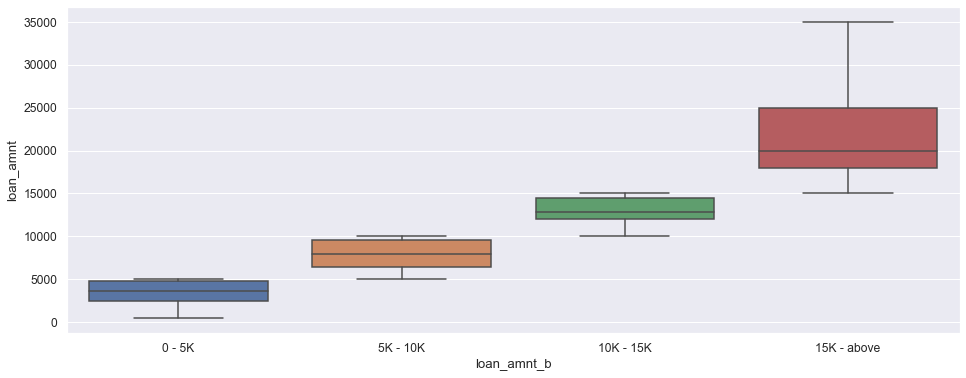

In [1005]:
# Validating Categories
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.loan_amnt_b)
plot.show()

In [1006]:
loan['funded_amnt_inv'].describe()

count    36847.000000
mean     10430.400868
std       7008.919433
min          0.000000
25%       5000.000000
50%       9000.000000
75%      14335.045000
max      35000.000000
Name: funded_amnt_inv, dtype: float64

In [1007]:
# Bucketting Funded Amount
def bucket_funded_amnt_inv(column):
    if column <= 5000:
        return '0 - 5K'  # 25% quartile
    elif (column >5000) and (column <= 10000):
        return '5K - 10K'      
    elif (column >10000) and (column <= 15000):
        return '10K - 15K'  
    else:
        return '15K - above' # 75% quartile
    
loan['funded_amnt_inv_b'] = loan.apply(lambda x : bucket_funded_amnt_inv(x['funded_amnt_inv']), axis = 1)

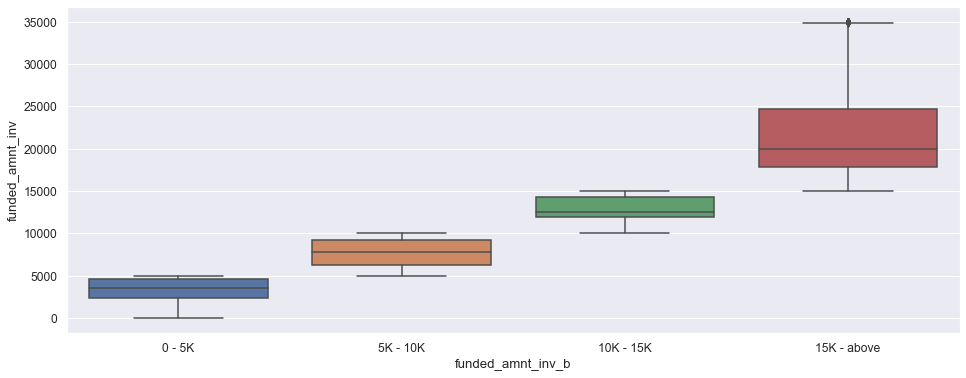

In [1008]:
# Validating Categories
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.funded_amnt_inv,x=loan.funded_amnt_inv_b)
plot.show()

In [1009]:
loan['funded_amnt'].describe()

count    36847.000000
mean     10872.924526
std       7109.330771
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

In [1010]:
# Bucketting Funded Amount
def bucket_funded_amnt(column):
    if column <= 5000:
        return '0 - 5K'  # 25% quartile
    elif (column >5000) and (column <= 10000):
        return '5K - 10K'      
    elif (column >10000) and (column <= 15000):
        return '10K - 15K'  
    else:
        return '15K - above' # 75% quartile
    
loan['funded_amnt_b'] = loan.apply(lambda x : bucket_funded_amnt(x['funded_amnt']), axis = 1)

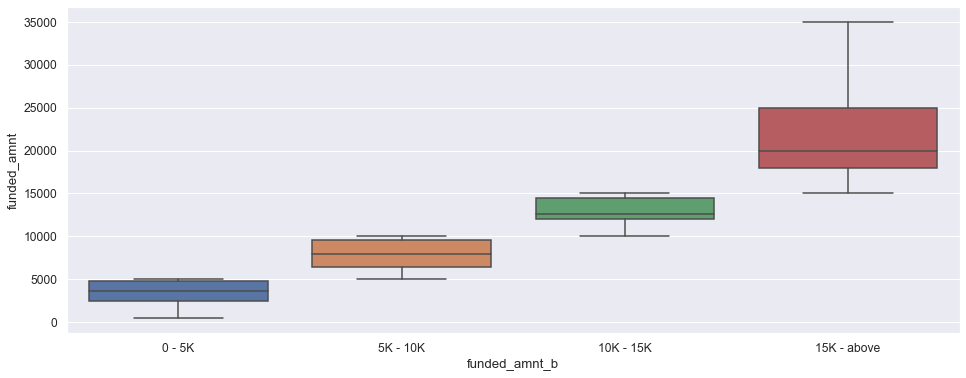

In [1011]:
# Validating Categories
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.funded_amnt,x=loan.funded_amnt_b)
plot.show()

In [1012]:
loan['annual_inc'].describe() / 1000

count      36.847000
mean       69.404482
std        64.027473
min         4.000000
25%        41.004000
50%        60.000000
75%        83.000000
max      6000.000000
Name: annual_inc, dtype: float64

In [1013]:
# Bucketing Annual Income
def bucket_annual_inc(column):
    if column <= 40000:
        return '0 - 40k' # 25% quartile
    elif (column >40000) and (column <= 50000):
        return '40k - 50k'    
    elif (column >50000) and (column <= 60000):
        return '50k to 60k'
    elif (column >60000) and (column <= 70000):
        return '60k to 70k'
    elif (column >70000) and (column <= 80000):
        return '70k to 80k'
    else:
        return '80k - above' # 75% quartile

loan['annual_inc_b'] = loan.apply(lambda x: bucket_annual_inc(x['annual_inc']), axis = 1)

In [1014]:
loan['int_rate'].describe()

count    36847.000000
mean        11.988346
std          3.702091
min          5.420000
25%          8.940000
50%         11.860000
75%         14.520000
max         24.400000
Name: int_rate, dtype: float64

In [1015]:
# Bucketing interest rate
def bucket_int_rate(column):
    if column <= 9:
        return 'Very Low' # 25% quartile
    elif (column >9) and (column <= 11):
        return 'Low'    
    elif (column >11) and (column <= 13):
        return 'Moderate'
    elif (column >13) and (column <= 15):
        return 'High'
    else:
        return 'Very High' # 75% quartile
    
loan['int_rate_b'] = loan.apply(lambda x : bucket_int_rate(x.int_rate), axis = 1)

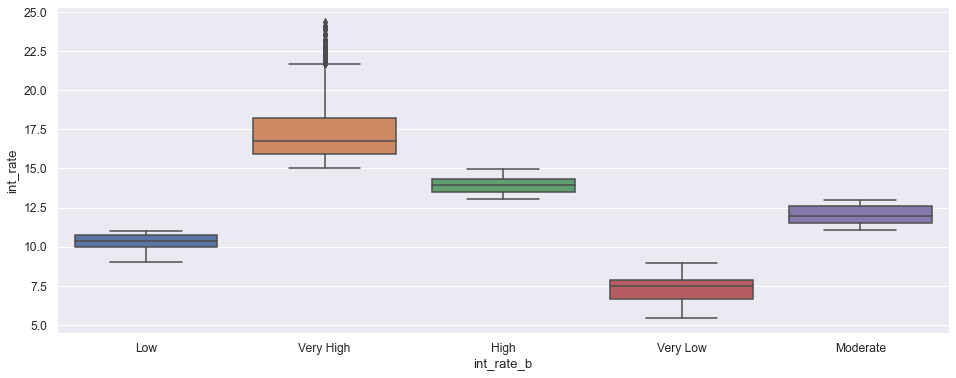

In [1016]:
# Validating Categories
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.int_rate,x=loan.int_rate_b)
plot.show()

In [1017]:
loan['dti'].describe()

count    36847.000000
mean        13.330449
std          6.651565
min          0.000000
25%          8.210000
50%         13.420000
75%         18.590000
max         29.990000
Name: dti, dtype: float64

In [1018]:
# Bucketing dti
def bucket_dti(column):
    if column <= 8:
        return 'Very Low' # 25% quartile
    elif (column >8) and (column <= 12):
        return 'Low'    
    elif (column >12) and (column <= 16):
        return 'Moderate'
    elif (column >16) and (column <= 20):
        return 'High'
    else:
        return 'Very High' # 75% quartile
    
loan['dti_b'] = loan.apply(lambda x : bucket_dti(x.dti), axis = 1)

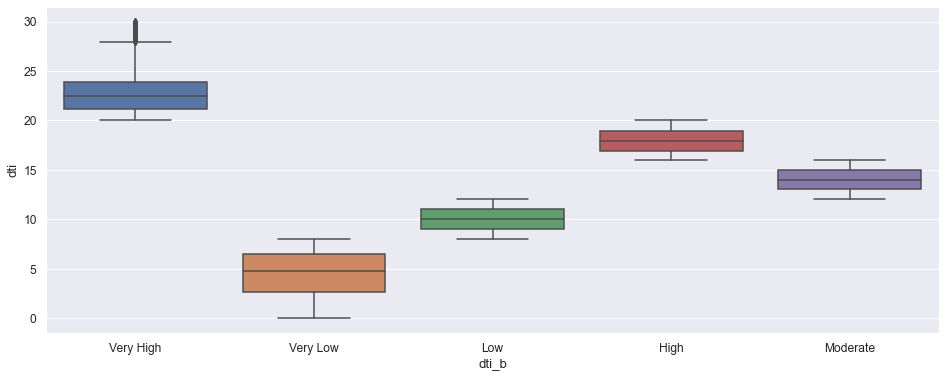

In [1019]:
# Validating Categories
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.dti,x=loan.dti_b)
plot.show()

### Data Analysis Post Cleanup

In [1020]:
# Printing column info to analyse missing values, empty values in a column
print(loan.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36847 entries, 0 to 39680
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    36847 non-null  int64         
 1   loan_amnt             36847 non-null  float64       
 2   funded_amnt           36847 non-null  float64       
 3   funded_amnt_inv       36847 non-null  float64       
 4   term                  36847 non-null  int64         
 5   int_rate              36847 non-null  float64       
 6   installment           36847 non-null  float64       
 7   grade                 36847 non-null  object        
 8   emp_length            36847 non-null  float64       
 9   home_ownership        36847 non-null  object        
 10  annual_inc            36847 non-null  float64       
 11  verification_status   36847 non-null  object        
 12  issue_d               36847 non-null  datetime64[ns]
 13  loan_status     

In [1021]:
loan.shape

(36847, 28)

In [1022]:
loan.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'pub_rec_bankruptcies', 'issue_y', 'issue_m',
       'issue_q', 'loan_amnt_b', 'funded_amnt_inv_b', 'funded_amnt_b',
       'annual_inc_b', 'int_rate_b', 'dti_b'],
      dtype='object')

In [1023]:
# Displaying retained columns in the final dataset which will be used for analysis
dict[dict['Column Status'] == "Retained"]

,LoanStatNew,Description,Column Status,Reason,Type Analysis
2,addr_state,The state provided by the borrower in the loan...,Retained,NaN,Unordered Categorical Variable
4,annual_inc,The self-reported annual income provided by th...,Retained,Important Attribute,NaN
16,dti,A ratio calculated using the borrower’s total ...,Retained,Important Attribute,NaN
19,emp_length,Employment length in years. Possible values ar...,Retained,Important Attribute,Ordered Categorical Variable
23,funded_amnt,The total amount committed to that loan at tha...,Retained,NaN,NaN
24,funded_amnt_inv,The total amount committed by investors for th...,Retained,NaN,NaN
25,grade,LC assigned loan grade,Retained,Important Attribute,Unordered Categorical Variable
26,home_ownership,The home ownership status provided by the borr...,Retained,Important Attribute,Unordered Categorical Variable
33,installment,The monthly payment owed by the borrower if th...,Retained,NaN,NaN
34,int_rate,Interest Rate on the loan,Retained,NaN,NaN


## Univeriate Analysis

In [1024]:
# Column metadata used by functions below
column_titles = {
    'loan_amnt': 'Loan Amount',
    'funded_amnt': 'Funded Amount',
    'funded_amnt_inv': 'Funded Amount Investors',
    'term': 'Loan Term',
    'int_rate': 'Interest Rate',
    'installment': 'Installment',
    'grade': 'Grade',
    'emp_length': 'Employment Length',
    'home_ownership': 'Home Owner Status',
    'annual_inc': 'Annuap Income', 
    'verification_status': 'Verification Status',
    'issue_d': 'Issue Date',
    'loan_status': 'Loan Status',
    'purpose': 'Purpose of Loan',
    'addr_state': 'State',
    'dti': 'Debt To Income Ratio',
    'pub_rec_bankruptcies': 'Bankruptcies Record',
    'issue_y': 'Issue Year',
    'issue_m': 'Issue Month',
    'issue_q': 'Issue Quarter',
    'loan_amnt_b': 'Loan Amount Bins',
    'funded_amnt_inv_b': 'Investor Funded Bins',
    'funded_amnt_b': 'Funded Amount Bins',
    'annual_inc_b': 'Annual Income Bins',
    'int_rate_b': 'Interest Rate Bins',
    'dti_b': 'DTI Bins'
}

### Common Functions

In [1025]:
# This function creates a dictionary of outliers which includes the inter quartile range, 
# lower and upper bound for a particular column.
# Formulae used in this analysis
# IQR = 75th Quartile - 25th Quartile
# Lower Bound = 25th Quartile - 1.5 * IQR
# Upper Bound = 75th Quartile + 1.5 * IQR

iqr_multiplier = 1.5

def get_iqr(df, column):
    quar25 = df[column].quantile(0.25)
    quar75 = df[column].quantile(0.75)
    iqr = quar75 - quar25
    lower = quar25 - iqr_multiplier * iqr
    upper = quar75 + iqr_multiplier * iqr
    return {'quartile1': quar25, 'quartile3': quar75, 'iqr': iqr, 'lower_bound': lower, 'upper_bound': upper}


# The function treat outliers, prints a box plot for each column under consideration
# Plot 1 = Before outlier treatment
# Plot 2 = Post outlier treatment
# Also prints statistics of how many rows and percentage of rows dropped
def outlier_comparison(df, column):
    # box plot before dropping outliers
    fig, p = plot.subplots(1,2,figsize=(14, 3))
    splot1 = sea.boxplot(df[column], ax=p[0], orient="h")
    splot1.set_title('Plot ['+ column + '] - Original')
    new_df = df[df[column] < get_iqr(df, column)['upper_bound']]
    # box plot after dropping outliers    
    splot2 = sea.boxplot(new_df[column], ax=p[1])
    splot2.set_title('Plot [' + column + '] - Post Outlier Treatment')
    plot.tight_layout()
    plot.show()
    
def drop_outlier(df, column):
    old_rows = len(df)
    new_df = df[df[column] < get_iqr(df, column)['upper_bound']]
    new_rows = len(new_df)
    print('Rows dropped: ', old_rows - new_rows)
    print('Percentage rows dropped: ', round((old_rows - new_rows)/old_rows*100,2), "%")
    return new_df


In [1026]:
def univariate_analysis(df, column):
    fig, p = plot.subplots(1,2, figsize=(16, 4))
    sea.distplot(df.loc[df[column].notnull(), column], kde=True, hist=True, ax=p[0])
    sea.boxplot(x=column, data=df, ax=p[1])
    p[0].set_xlabel(column_titles[column])
    p[1].set_xlabel(column_titles[column])
    plot.tight_layout()
    plot.show()

In [1027]:
# Bivariate analysis of columns against loan_status and calculate the ratio of Charge Offs
def analysis_vs_loan_status(df, col):
    fig, p = plot.subplots(1,2, figsize=(16, 4))
    splot = sea.countplot(df[col], ax=p[0])
    splot.set_xticklabels(splot.get_xticklabels(), rotation=90);
    p[0].set_title('['+ col + '] - loan_status=all')
    cross_tab = pd.crosstab(df[col], df['loan_status'], normalize='index')
    cross_tab.plot.bar(ax=p[1], stacked=True)
    p[1].set_title('['+ col + '] - Stacked')
    plot.show()


def continious_column_analysis(df, column):
    f, (ax1, ax2) = plot.subplots(nrows=1, ncols=2, figsize=(16,4))
    sea.distplot(df.loc[df[column].notnull(), column], kde=True, hist=True, ax=ax1)
    sea.boxplot(x=column, y='loan_status', data=df, ax=ax2)
    ax1.set_xlabel(column_titles[column])
    ax2.set_xlabel(column_titles[column] + 'by Loan Status')
    plot.tight_layout()
    plot.show()
    # return group by dataframe for display comparison
    return df.groupby('loan_status')[column].describe()

def comparison_loan_status(df, column):
    df.groupby('loan_status')[column].value_counts().unstack().plot(kind='bar', figsize=[16,4])
    plot.show()


def ratio_wise(df, column):
    rw = df.pivot_table(index=column, columns='loan_status', values='id', aggfunc=len).reset_index()
    rw['total'] = rw['Charged Off'] + rw['Fully Paid']
    rw['charge_off_ratio'] = round(rw['Charged Off'] / rw['total'] * 100)
    rw.sort_values(by='total', ascending=False)
    return rw

def ratio_wise_plot(df, column, invert=False):
    plot.figure(figsize=[20,8])
    plot.title('Charged Off : ' + column_titles[column])
    rw = ratio_wise(df, column)
    if invert:
        sea.barplot(rw['charge_off_ratio'], rw[column])
    else:
        sea.barplot(rw[column], rw['charge_off_ratio'])
    plot.tight_layout()
    plot.show()
    return rw

def series_plot(df, column, hue=None, annot=1):
        temp = pd.Series()
        fig, ax = plot.subplots(figsize=(20,14))
        width = len(df[column].unique()) + 6 + 4 * len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sea.countplot(data = df, x=column, order=df[column].value_counts().index, hue=hue) 
        if annot == 1:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
        elif annot == 2:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
        plot.show()

***

## Outlier Treatment

Outlier treatment of the key variables and drop the outliers for cleaner data analysis

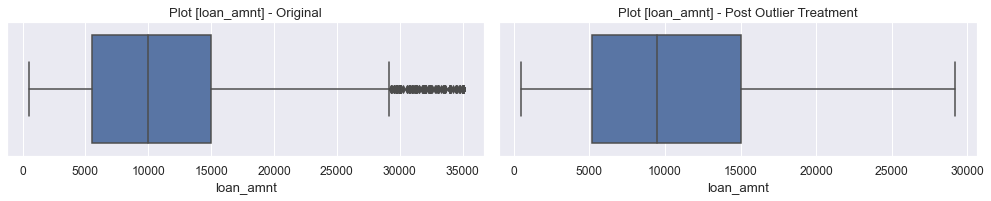

Rows dropped:  1078
Percentage rows dropped:  2.93 %


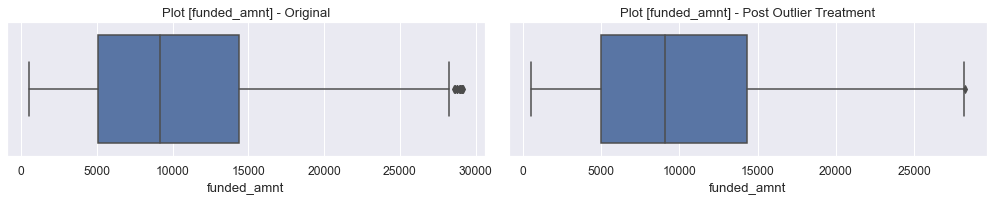

Rows dropped:  30
Percentage rows dropped:  0.08 %


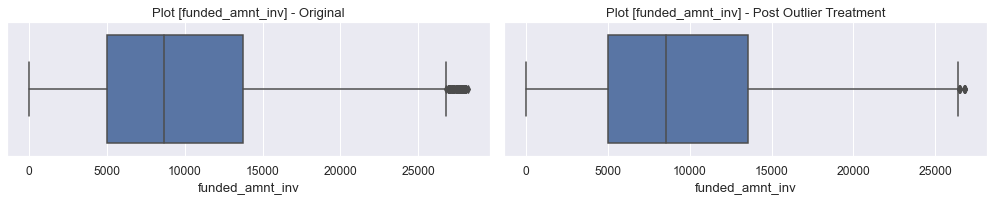

Rows dropped:  153
Percentage rows dropped:  0.43 %


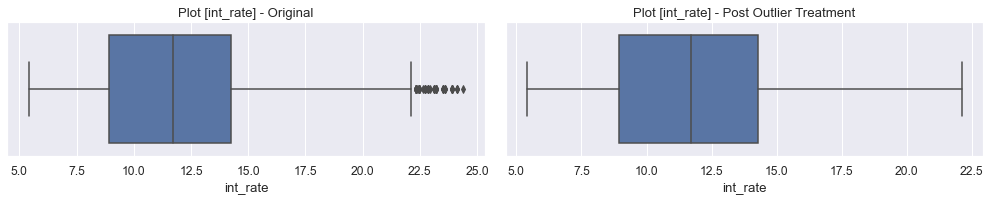

Rows dropped:  63
Percentage rows dropped:  0.18 %


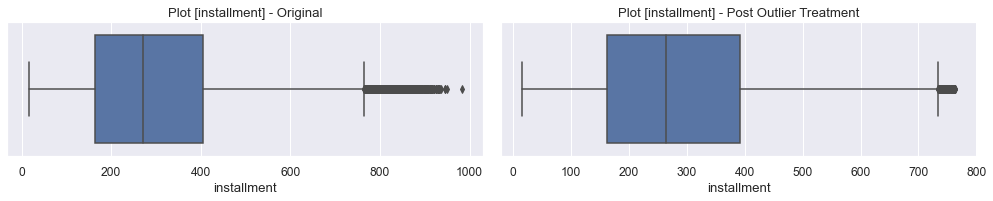

Rows dropped:  981
Percentage rows dropped:  2.76 %


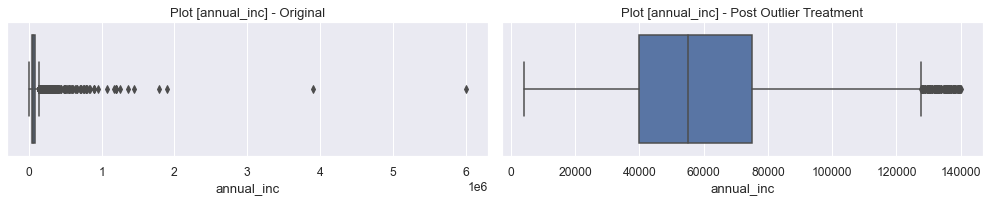

Rows dropped:  1486
Percentage rows dropped:  4.3 %


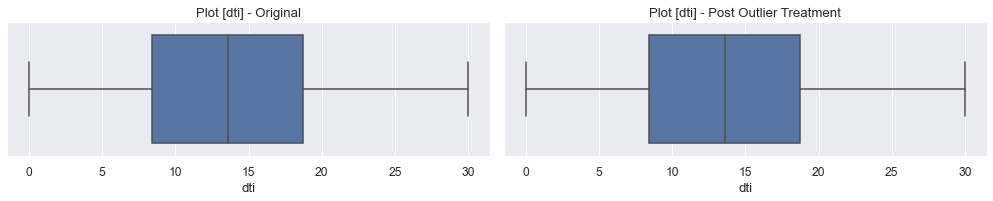

Rows dropped:  0
Percentage rows dropped:  0.0 %


In [1028]:
original_row_count = len(loan)

outlier_treatment = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti']
for column in outlier_treatment:
    outlier_comparison(loan, column)
    loan = drop_outlier(loan, column)

In [1029]:
new_row_count = len(loan)
print('Rows dropped: ', original_row_count - new_row_count)
print('Percentage rows dropped: ', round((original_row_count - new_row_count)/original_row_count*100,2), "%")

Rows dropped:  3791
Percentage rows dropped:  10.29 %


***

## Quantitative Variable Analysis

### loan_amnt

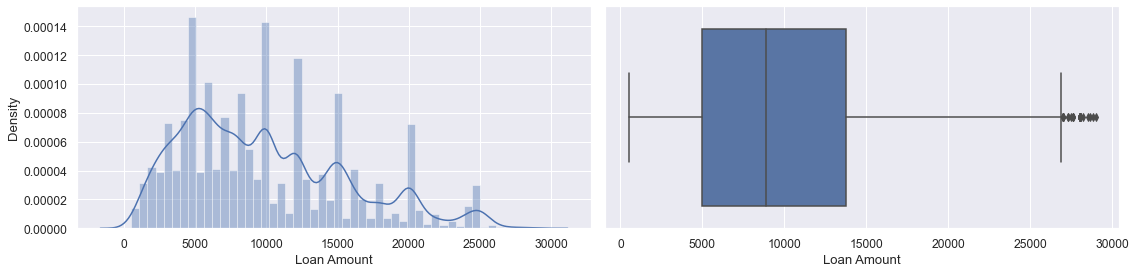

In [1030]:
univariate_analysis(loan, 'loan_amnt')

**Majority of the loan_amount is in the range of 5K to 14K**
***

### funded_amnt

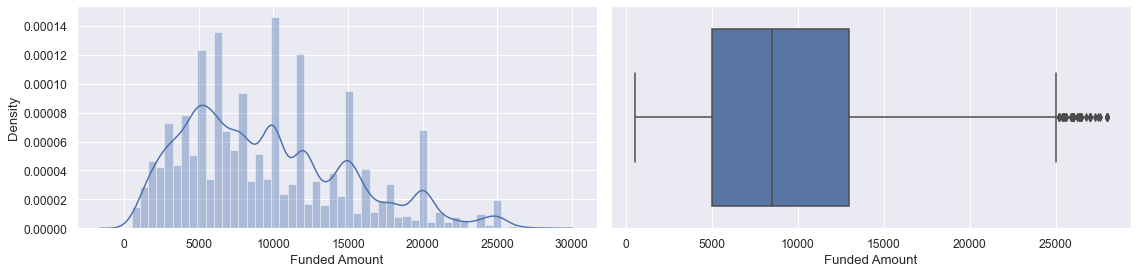

In [1031]:
univariate_analysis(loan, 'funded_amnt')

**Majority of the funded_amnt is in the range of 5K to 13K**
***

### funded_amnt_inv

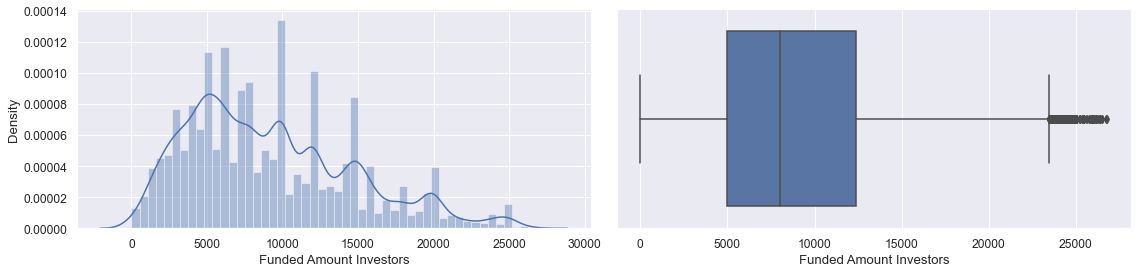

In [1032]:
univariate_analysis(loan, 'funded_amnt_inv')

**Majority of the funded_amnt_inv is in the range of 5K to 12K**
***

### int_rate

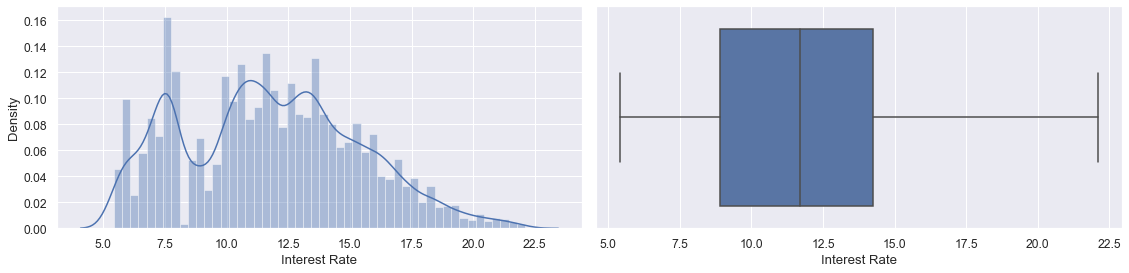

In [1033]:
univariate_analysis(loan, 'int_rate')

**Majority of the interest rate is in the range of 5% to 16% going at the max to 22%**
***

### installment

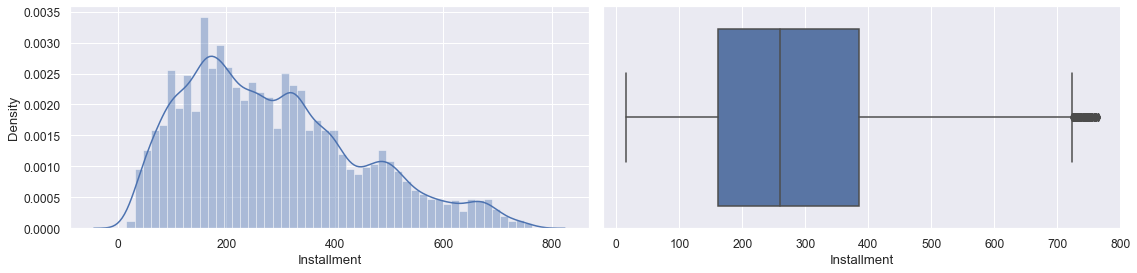

In [1034]:
univariate_analysis(loan, 'installment')

**Majority of the installment is in the range of 20 to 400 going at the max to 700**
***

### annual_inc

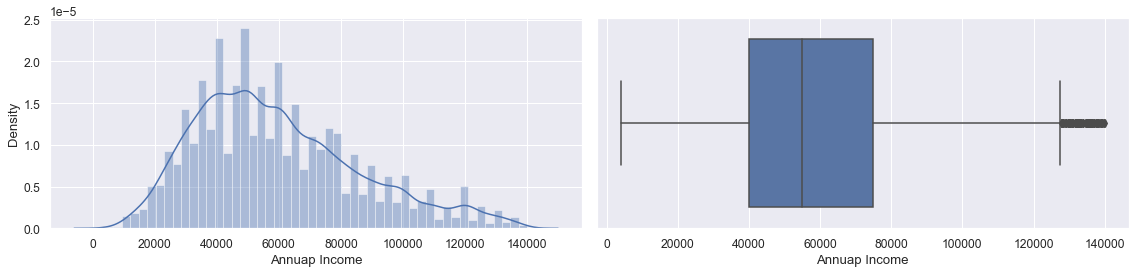

In [1035]:
univariate_analysis(loan, 'annual_inc')

**Majority of the annual income is in the range of 4k to 40k going at the max to 120k**. This column required major outlier treatment.
***

### dti

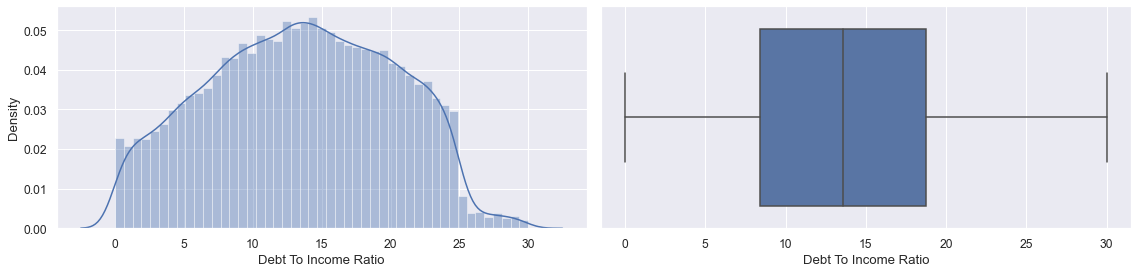

In [1036]:
univariate_analysis(loan, 'dti')

**Majority of the debt to income is in the range of 0 to 20 going at the max to 30**
***

## Unordered Categorical Variable Analysis

### home_ownership

<AxesSubplot:>

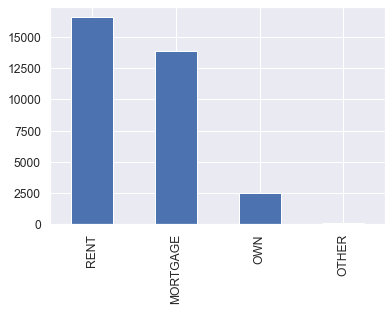

In [1037]:
loan['home_ownership'].value_counts().plot.bar()

**Majority of the home owner status are in status of RENT and MORTGAGE**

### purpose

<AxesSubplot:>

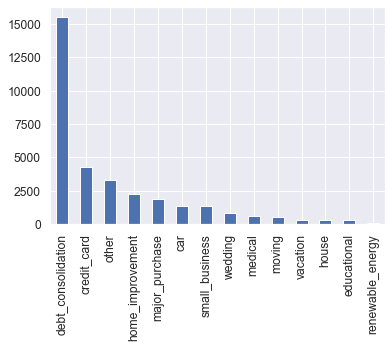

In [1038]:
loan['purpose'].value_counts().plot.bar()

Majority of loan application are in the category of debt_consolidation

### addr_state

<AxesSubplot:>

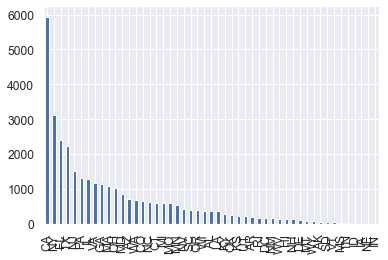

In [1039]:
loan['addr_state'].value_counts().plot.bar()

CA state has the maximum amount of loan applications

## Ordered Categorical Variable Analysis

### term

<AxesSubplot:>

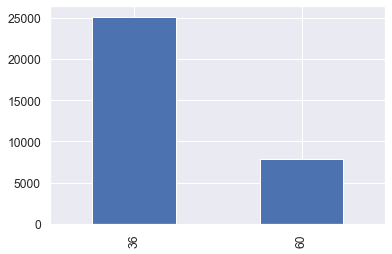

In [1040]:
loan['term'].value_counts().plot.bar()

Majority of the loan applications counts are in the term of 36 months.

### grade

<AxesSubplot:>

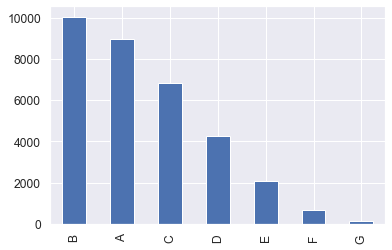

In [1041]:
loan['grade'].value_counts().plot.bar()

Majority of loan application counts fall under the catogory of **Grade B**

### emp_length

<AxesSubplot:>

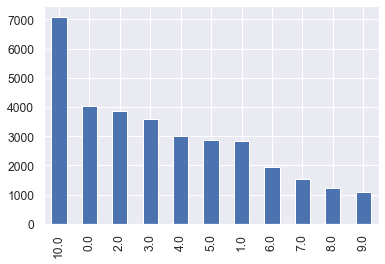

In [1042]:
loan['emp_length'].value_counts().plot.bar()

**Majority of the employment length of the customers are 10+ years and then in the range of 0-2 years**

### pub_rec_bankruptcies

<AxesSubplot:>

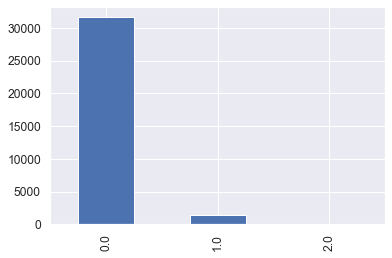

In [1043]:
loan['pub_rec_bankruptcies'].value_counts().plot.bar()

Majority of the loan applicants are in the category of not having an public record of bankruptcies

## Derived Variable Analysis

### issue_y

<AxesSubplot:>

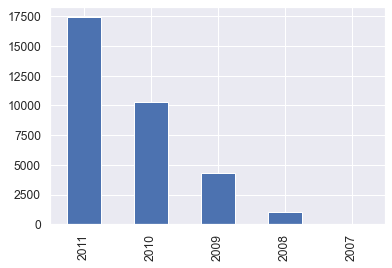

In [1044]:
loan['issue_y'].value_counts().plot.bar()

Loan application counts are increasing year over year. 
Maybe the risk exposure is increasing over the year (un proven hypothesis)

### issue_m

<AxesSubplot:>

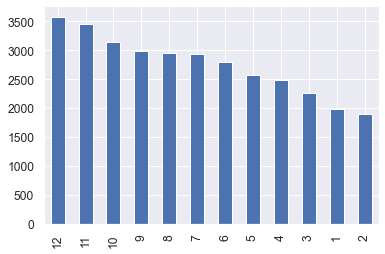

In [1045]:
loan['issue_m'].value_counts().plot.bar()

The lowest loans applocation count are in the month of Jan/Feb/March and highest counts are in 10/11/12. 
 - Possibly because by year ends people face the financial challenges
 - Possibly because of festive seasons
 - Possibly because they are consolidating debt by year end


### issue_q

<AxesSubplot:>

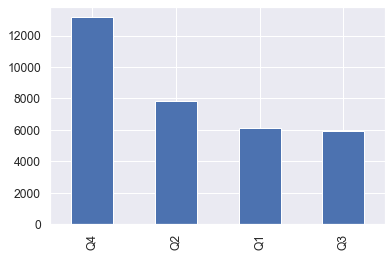

In [1046]:
loan['issue_q'].value_counts().plot.bar()

Highest loan application volume in Quarter 4 of a year

### loan_amnt_b

<AxesSubplot:>

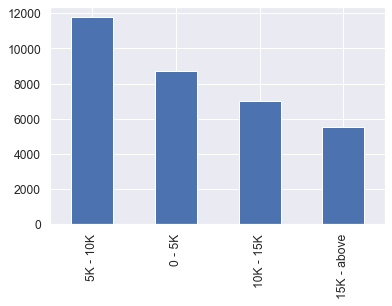

In [1047]:
loan['loan_amnt_b'].value_counts().plot.bar()

Highest loan amount applications fall in the range of 5k to 10k

### funded_amnt_b

<AxesSubplot:>

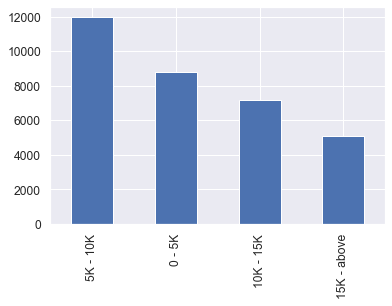

In [1048]:
loan['funded_amnt_b'].value_counts().plot.bar()

Highest funded amount applications fall in the range of 5k to 10k

### funded_amnt_inv_b

<AxesSubplot:>

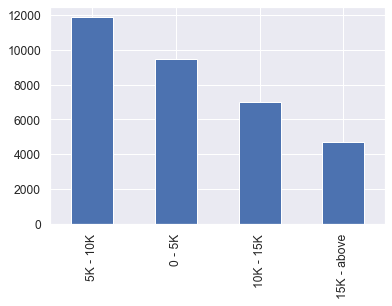

In [1049]:
loan['funded_amnt_inv_b'].value_counts().plot.bar()

Highest loan amount applications fall in the range of 5k to 10k

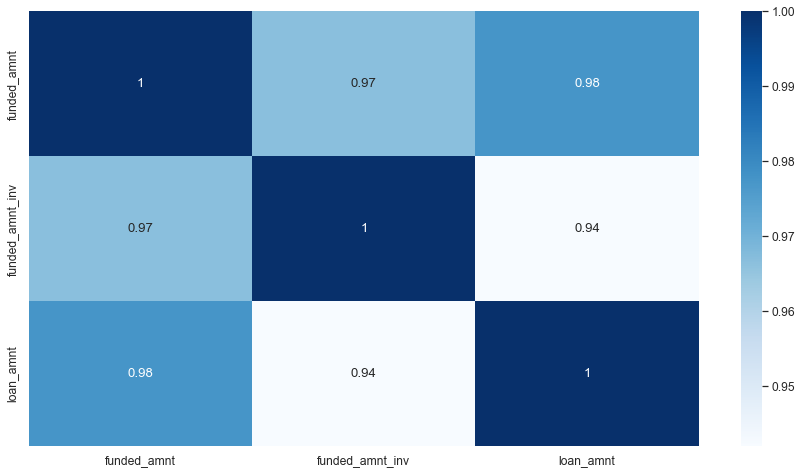

In [1050]:
# Identifying key correlations
corr = loan.loc[:, [ 'funded_amnt', 'funded_amnt_inv', 'loan_amnt']].corr()
plot.figure(figsize = (15,8))
sea.heatmap(corr, annot = True, cmap='Blues')
plot.show()

The loan_amt, funded_amt and funded_amt_inv may is highly positively correlated. dropping ```funded_amnt_inv``` and ```funded_amnt```

In [1051]:
 # Dropping funded_amnt and funded_amnt_inv
loan = loan.drop(['funded_amnt_inv', 'funded_amnt'],  axis=1)

### annual_inc_b

<AxesSubplot:>

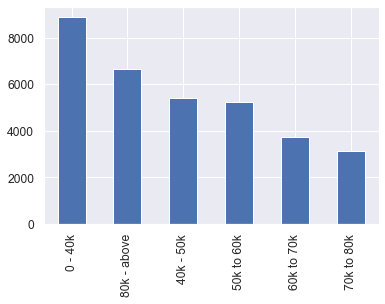

In [1052]:
loan['annual_inc_b'].value_counts().plot.bar()

Majority of the loan applocants are in the range of 0 - 40K anual income

### int_rate_b

<AxesSubplot:>

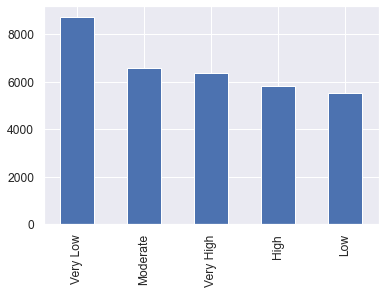

In [1053]:
loan['int_rate_b'].value_counts().plot.bar()

Majority of the loan applocations are in the category of Very Low interest rates

### dti_b

<AxesSubplot:>

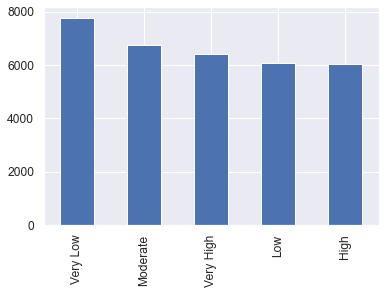

In [1054]:
loan['dti_b'].value_counts().plot.bar()

Majority of the loan applications are in Moderate debt to income ratio

## Univariate Analysis Summary

### Customer Demographics
- Majority of the loan applicants are in the range of 0 - 40K annual income
- Majority of the debt to income is in the range of 0 to 20 going at the max to 30
- Majority of the home owner status are in status of RENT and MORTGAGE
- Highest loan applications are in the category of debt_consolidation
- CA (California) state has the maximum amount of loan applications
- Majority of the loan applicants are in the category of not having an public record of bankruptcies
- Majority of the employment length of the customers are 10+ years and then in the range of 0-2 years

### Loan Demographics
- Highest loan amount applications fall in the range of 5k to 10k
- Majority of the interest rate is in the range of 5% to 16% going at the max to 22%
- Majority of the installment amount is in the range of 20$ to 400$
- Majority of the loan applications counts are in the term of 36 months
- Majority of loan application counts fall under the catogory of Grade B

### Time Based Analysis
- Loan application counts are increasing year over year
- Highest loan application volume in Quarter 4 of every year
- Lowest loan applications are in Q1
     - Possibly because by year ends people face the financial challenges
     - Possibly because of festive seasons
     - Possibly because they are consolidating debt by year end

### Inferences
- The customer demographic data shws which segment of customers to target for highest volume of loan
- Indicates more analysis is needed why other categories are not as high as other few
- Indicates the LendingClub to be prepared with volume in Q4
- Indicates the LendingClub to target customers in other quarters to increase sales

In [1055]:
# Printing column info to analyse missing values, empty values in a column
print(loan.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33056 entries, 0 to 39680
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    33056 non-null  int64         
 1   loan_amnt             33056 non-null  float64       
 2   term                  33056 non-null  int64         
 3   int_rate              33056 non-null  float64       
 4   installment           33056 non-null  float64       
 5   grade                 33056 non-null  object        
 6   emp_length            33056 non-null  float64       
 7   home_ownership        33056 non-null  object        
 8   annual_inc            33056 non-null  float64       
 9   verification_status   33056 non-null  object        
 10  issue_d               33056 non-null  datetime64[ns]
 11  loan_status           33056 non-null  object        
 12  purpose               33056 non-null  object        
 13  zip_code        

In [1056]:
loan.head()

,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec_bankruptcies,issue_y,issue_m,issue_q,loan_amnt_b,funded_amnt_inv_b,funded_amnt_b,annual_inc_b,int_rate_b,dti_b
0,1077501,5000.0,36,10.65,162.87,B,10.0,RENT,24000.0,Verified,...,0.0,2011,12,Q4,0 - 5K,0 - 5K,0 - 5K,0 - 40k,Low,Very High
1,1077430,2500.0,60,15.27,59.83,C,0.0,RENT,30000.0,Source Verified,...,0.0,2011,12,Q4,0 - 5K,0 - 5K,0 - 5K,0 - 40k,Very High,Very Low
2,1077175,2400.0,36,15.96,84.33,C,10.0,RENT,12252.0,Not Verified,...,0.0,2011,12,Q4,0 - 5K,0 - 5K,0 - 5K,0 - 40k,Very High,Low
3,1076863,10000.0,36,13.49,339.31,C,10.0,RENT,49200.0,Source Verified,...,0.0,2011,12,Q4,5K - 10K,5K - 10K,5K - 10K,40k - 50k,High,High
5,1075269,5000.0,36,7.90,156.46,A,3.0,RENT,36000.0,Source Verified,...,0.0,2011,12,Q4,0 - 5K,0 - 5K,0 - 5K,0 - 40k,Very Low,Low


In [1057]:
# Taking a data snapshot
loan.to_csv('./.data/snapshot.loan.csv') 

***

## Bivariate Analysis

### Analysis vs Charged Off Status

Identify causes and data which contribute to more Charge Off's

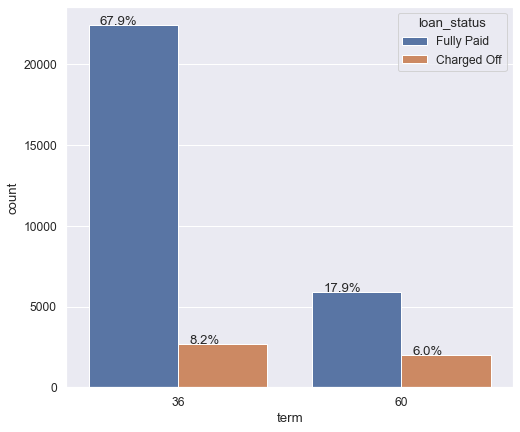

In [1060]:
# Overall ratio of Charge Offs
series_plot(loan, 'term', 'loan_status')

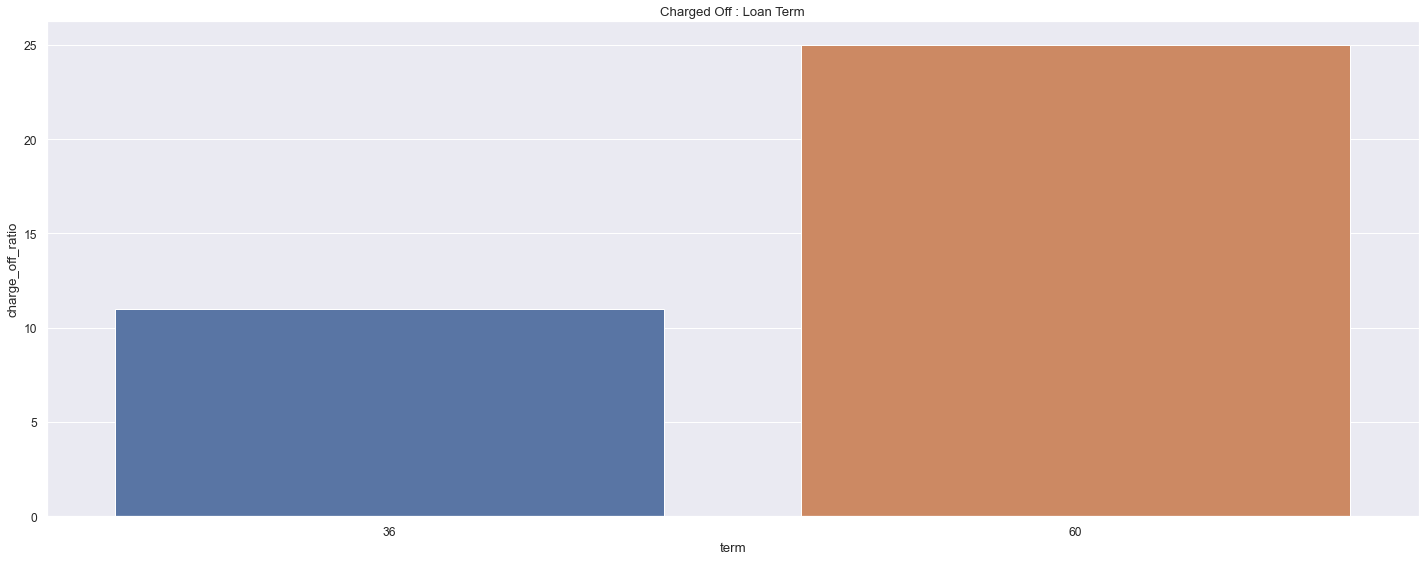

loan_status,term,Charged Off,Fully Paid,total,charge_off_ratio
0,36,2710,22429,25139,11.0
1,60,1990,5927,7917,25.0


In [1061]:
## The ratio of Charge Offs within the category
ratio_wise_plot(loan, 'term')

***
- The volume of loans are in the category of term = 36
- The overall percentage of Charge Off's is slightly higher in term = 36 (8%) as compared to term=60 (6%)
- If we calculate the ratio of Charge Off's within a category
    - **Charge Off**s ratio is for the term=60 is 25% which is much higher than term=36 (10%)
    - **term=60 is the loan applications which require more scrutiny**
- **Inferences**
    - Most of the applicants with term=60 potentially will have high Charge Offs
***

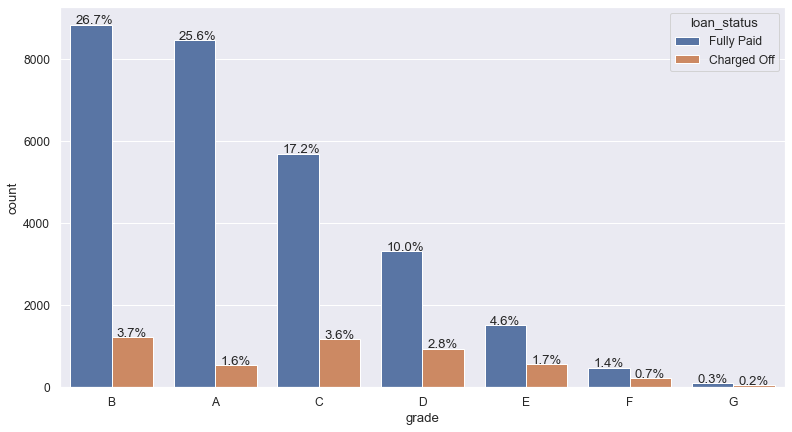

In [1062]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'grade', 'loan_status')

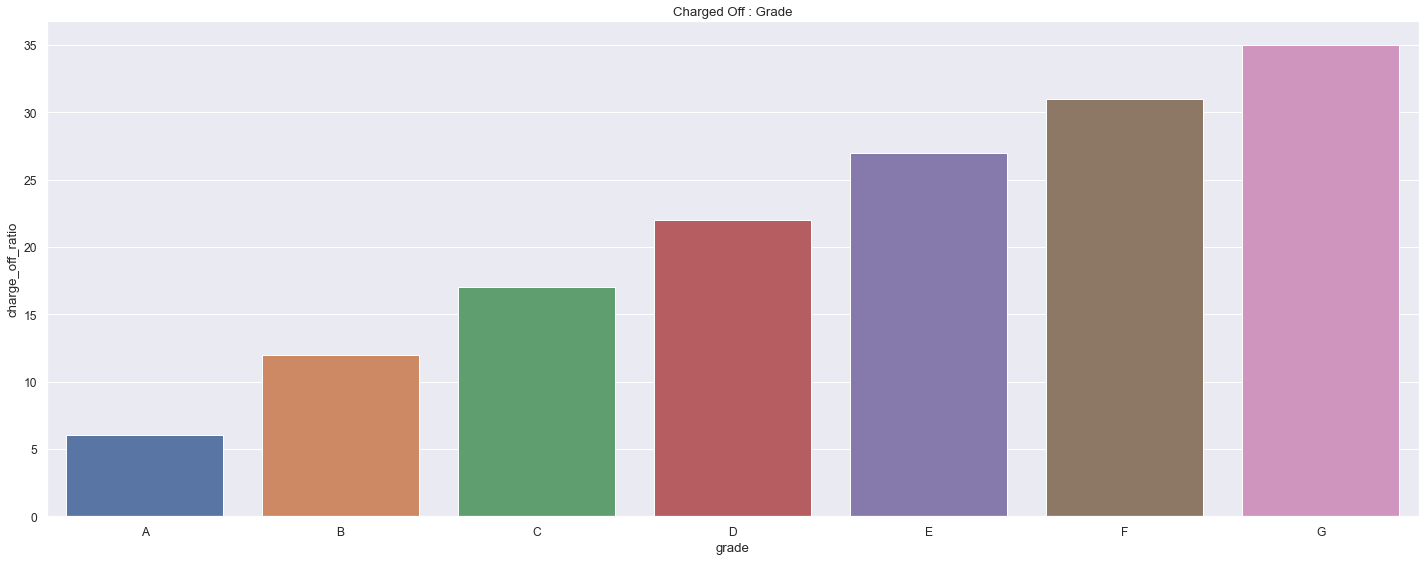

loan_status,grade,Charged Off,Fully Paid,total,charge_off_ratio
0,A,537,8451,8988,6.0
1,B,1222,8821,10043,12.0
2,C,1175,5683,6858,17.0
3,D,937,3316,4253,22.0
4,E,555,1505,2060,27.0
5,F,219,477,696,31.0
6,G,55,103,158,35.0


In [1063]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'grade')

***
- The Majority of *loan volume is in grade=B*
- Highest percentage of overall Charge Offs are in grade B (3.7%) and C(3.6%)
- If we analyse the Charge Off Ratio within a category
    - The highest percentage of **Charge Off**s are in the *grade=G*
    - Highest cluster of **Charge Off**s are in the grades G,F (> 30%)
    - The volume of Grade G is extremely low 158 thus it does not contribute to overall risk significantly
- **Inferences**
    - Highest risk of charge off's are in the grades of B and C
    - Grade "F" and "G" have very high chances of charged off. The columes are low
    - Grade "A" has very less chances of charged off.
    - Probablity of charged off is increasing from "A" to "G"
***

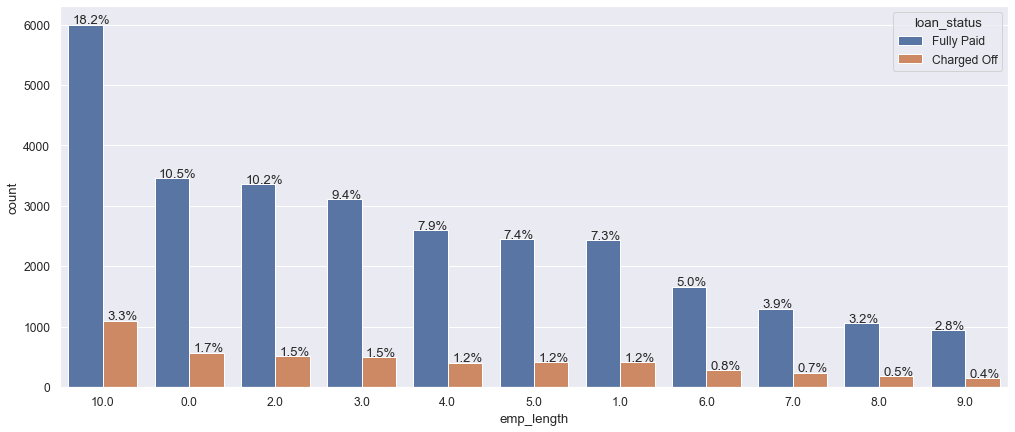

In [1064]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'emp_length', 'loan_status')

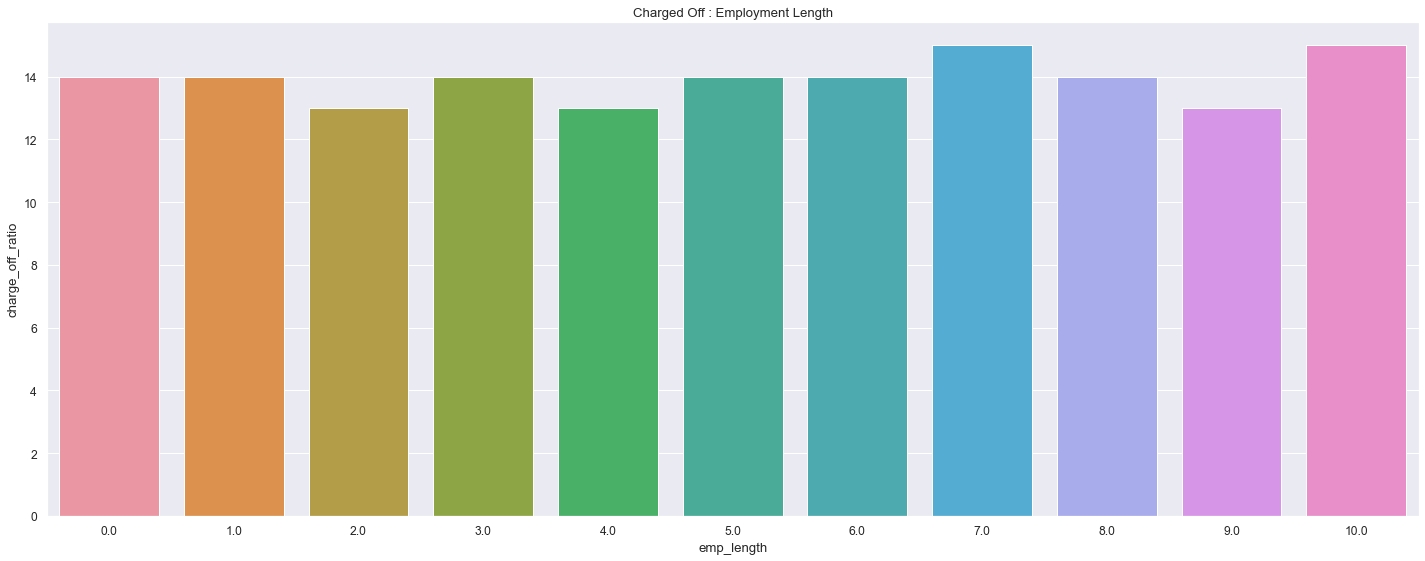

loan_status,emp_length,Charged Off,Fully Paid,total,charge_off_ratio
0,0.0,565,3461,4026,14.0
1,1.0,408,2427,2835,14.0
2,2.0,509,3360,3869,13.0
3,3.0,491,3113,3604,14.0
4,4.0,401,2598,2999,13.0
5,5.0,408,2449,2857,14.0
6,6.0,272,1659,1931,14.0
7,7.0,233,1294,1527,15.0
8,8.0,176,1056,1232,14.0
9,9.0,141,936,1077,13.0


In [1065]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'emp_length')

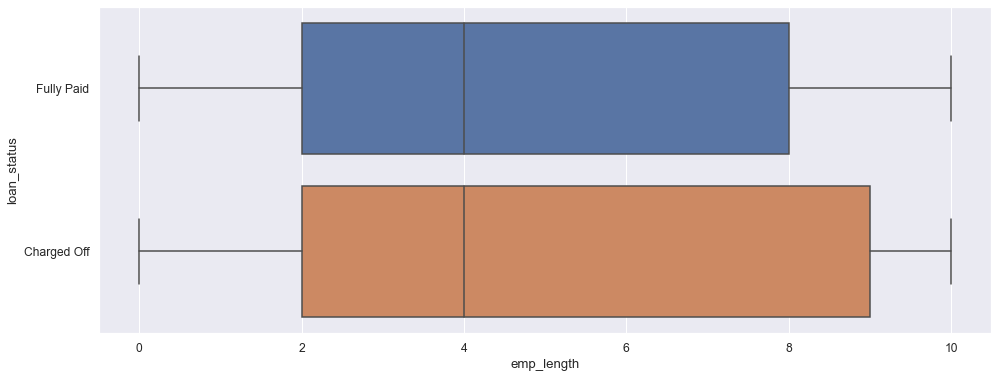

In [1066]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_status,x=loan.emp_length)
plot.show()

***
- Highest Charge Offs are in the employee length categoty of 10 Years and above
- Charge Off ratio within the categories itself are similar and inconclusive
- **Inferences**
    - Highest Charge Offs are in the employee length of 10 Years and above
    - High probablity of Charge Off's whose income range is less than 1 years
    - Ratio within the ranges are pretty much same (in conclusive)
***

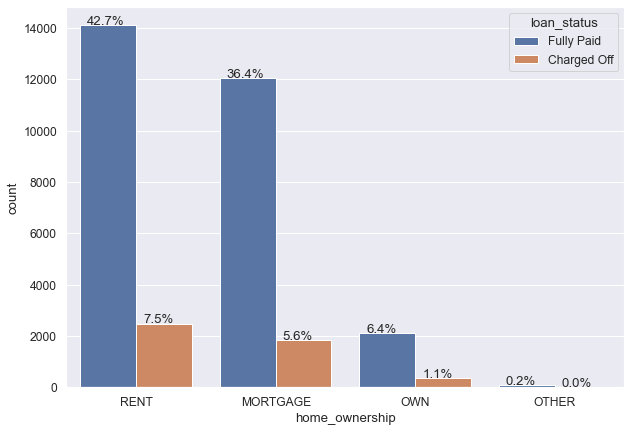

In [1067]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'home_ownership', 'loan_status')

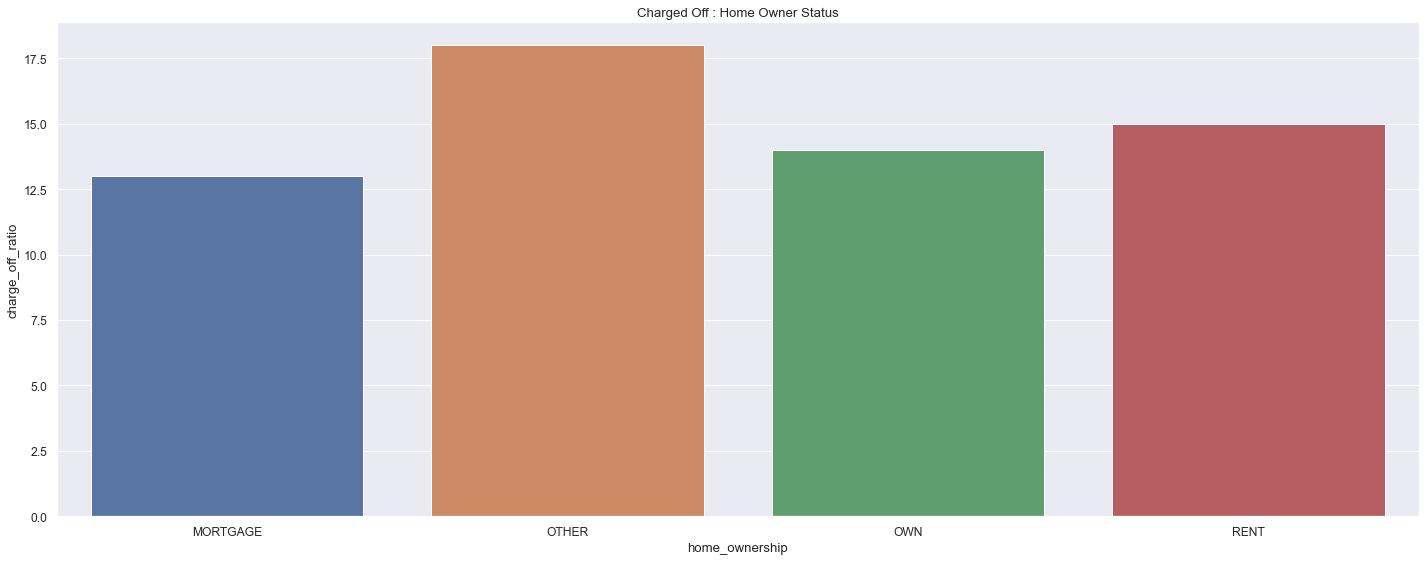

loan_status,home_ownership,Charged Off,Fully Paid,total,charge_off_ratio
0,MORTGAGE,1846,12045,13891,13.0
1,OTHER,16,73,89,18.0
2,OWN,354,2113,2467,14.0
3,RENT,2484,14125,16609,15.0


In [1068]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'home_ownership')

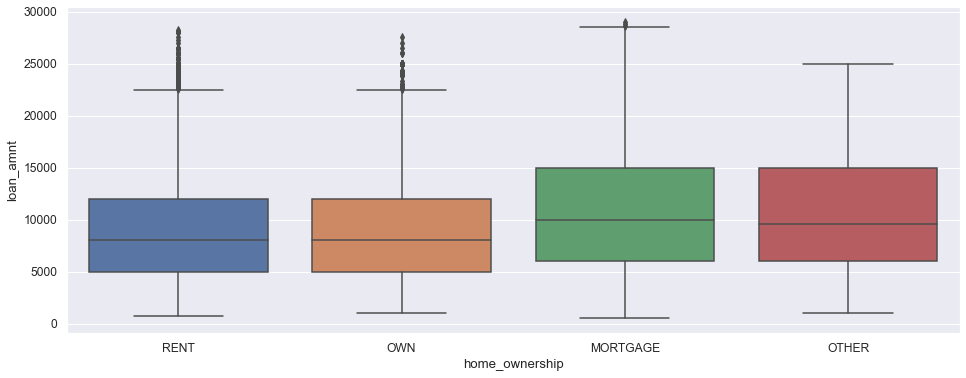

In [1069]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.home_ownership)
plot.show()

***
- Overall highest Charge Off numbers are in the category of RENT and MORTGAGE
- Within each home_ownership category the ratio of Charge Off's for Other is higher
- **Inferences**
    - The home_ownership status of MORTGAGE and are at the highest risk of Charge Offs
    - MORTGAGE status also has the highest range of loan amounts increasing the risk
***

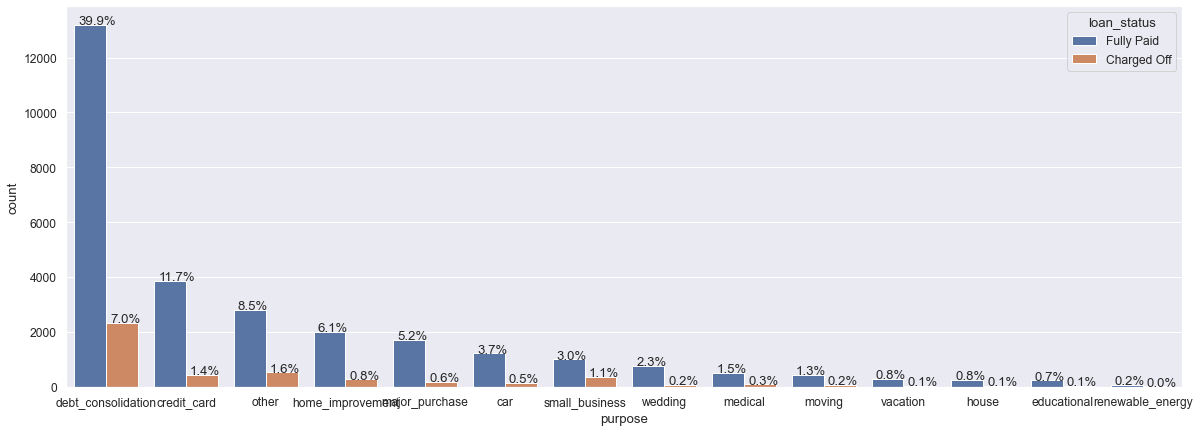

In [1070]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'purpose', 'loan_status')

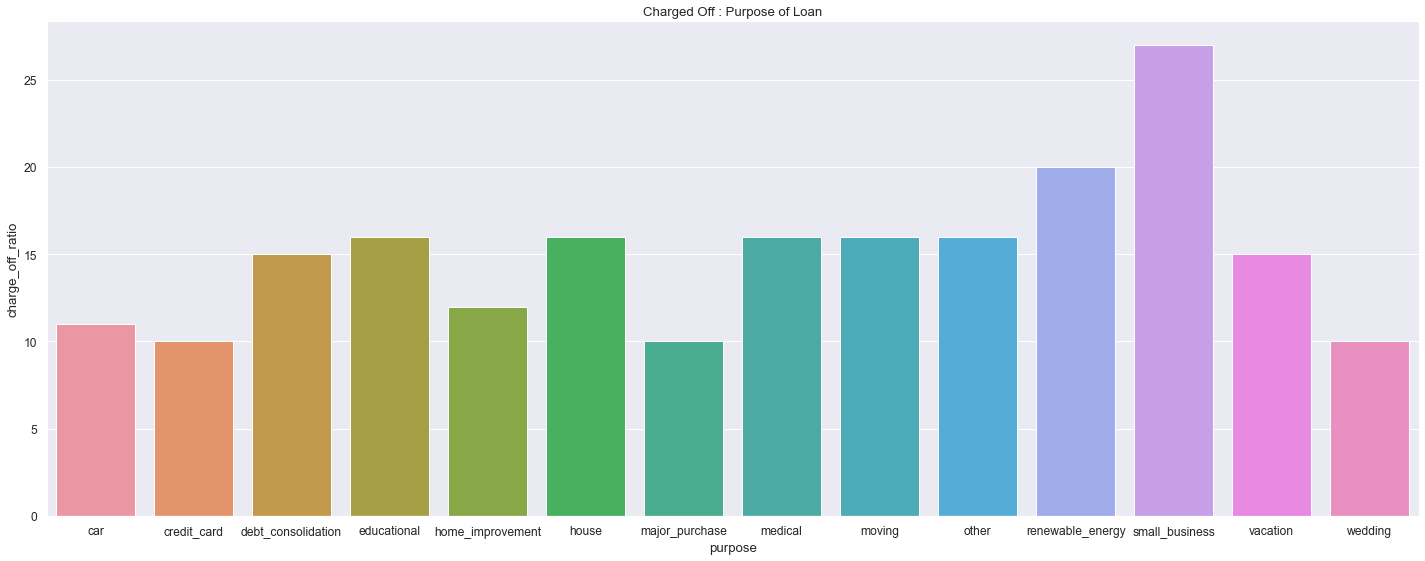

loan_status,purpose,Charged Off,Fully Paid,total,charge_off_ratio
0,car,150,1221,1371,11.0
1,credit_card,448,3868,4316,10.0
2,debt_consolidation,2325,13203,15528,15.0
3,educational,46,235,281,16.0
4,home_improvement,274,2014,2288,12.0
5,house,48,248,296,16.0
6,major_purchase,194,1710,1904,10.0
7,medical,95,509,604,16.0
8,moving,79,428,507,16.0
9,other,531,2818,3349,16.0


In [1071]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'purpose')

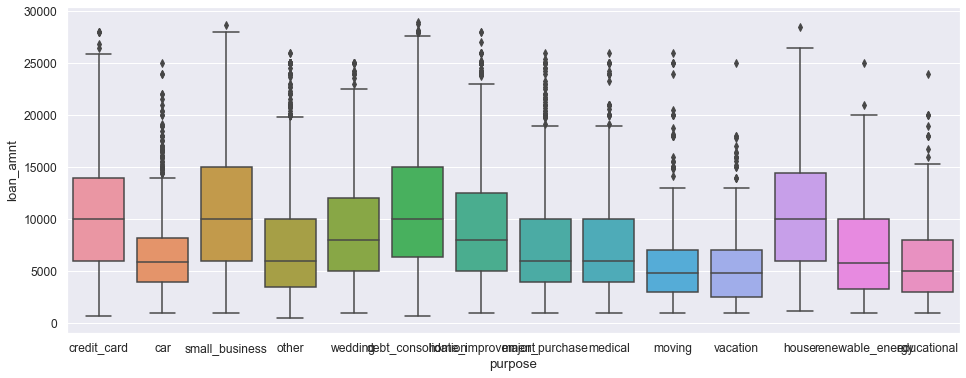

In [1072]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.purpose)
plot.show()

***
- Highest risk of Charge Offs are the category of debt_consolidation
- Highest probablity of Charge Offs within a category are small_business but the volume is extremely low
- Highest loan amount ranges are in small business, debt consolidation and house
- **Inferences**
    - Highest risk of Charge Off's are the purpose of debt_consolidation
    - Small Business applicants have high chances of getting charged off.
    - renewable_energy has lowest risk of Charge Off's in volume
***

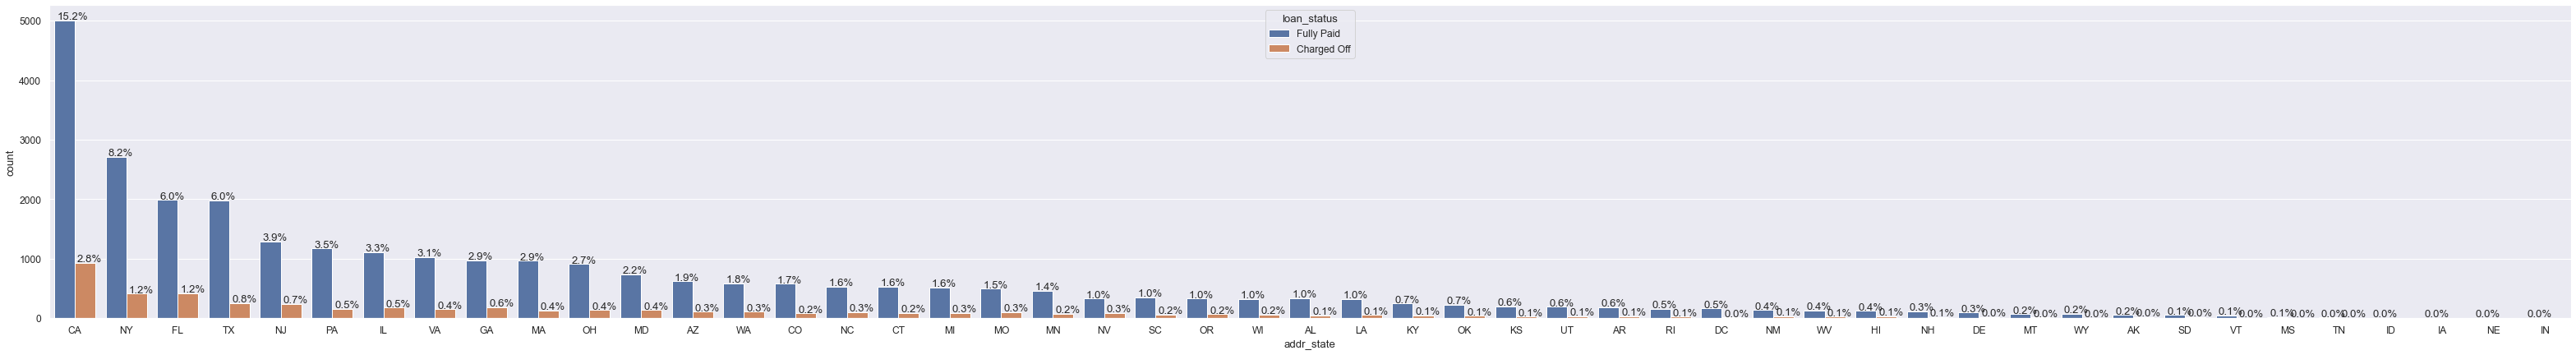

In [1073]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'addr_state', 'loan_status')

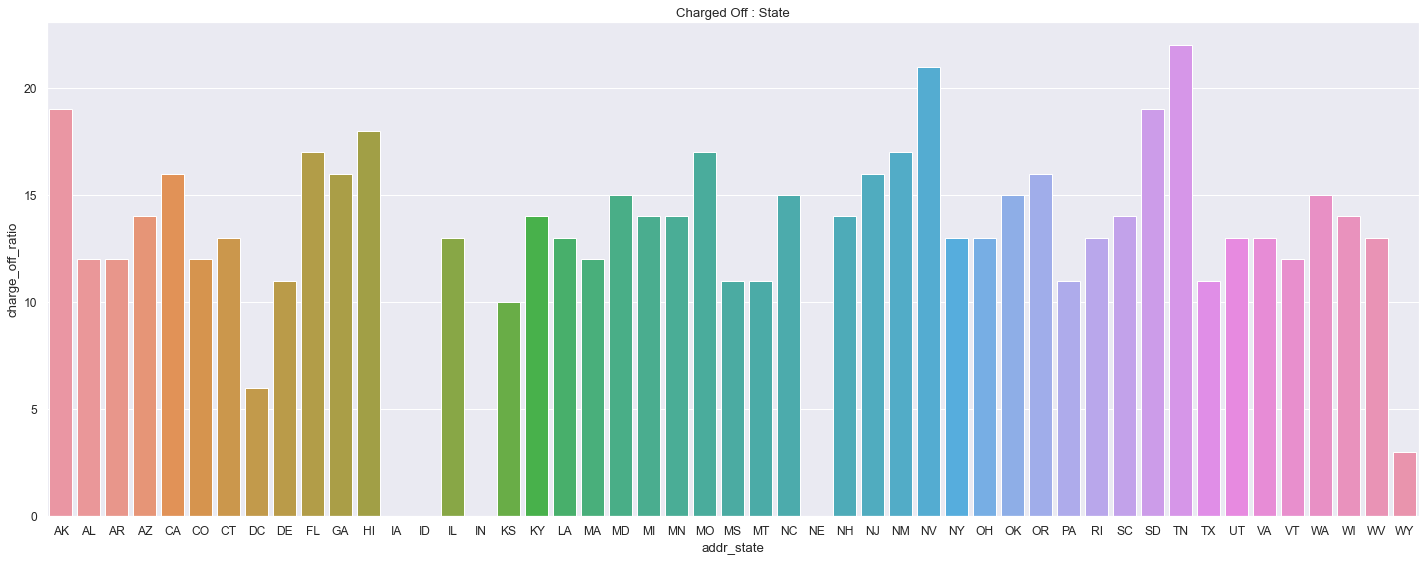

loan_status,addr_state,Charged Off,Fully Paid,total,charge_off_ratio
0,AK,12.0,51.0,63.0,19.0
1,AL,45.0,330.0,375.0,12.0
2,AR,25.0,183.0,208.0,12.0
3,AZ,103.0,618.0,721.0,14.0
4,CA,930.0,5009.0,5939.0,16.0
5,CO,77.0,576.0,653.0,12.0
6,CT,80.0,526.0,606.0,13.0
7,DC,10.0,162.0,172.0,6.0
8,DE,11.0,90.0,101.0,11.0
9,FL,413.0,1984.0,2397.0,17.0


In [1074]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'addr_state')

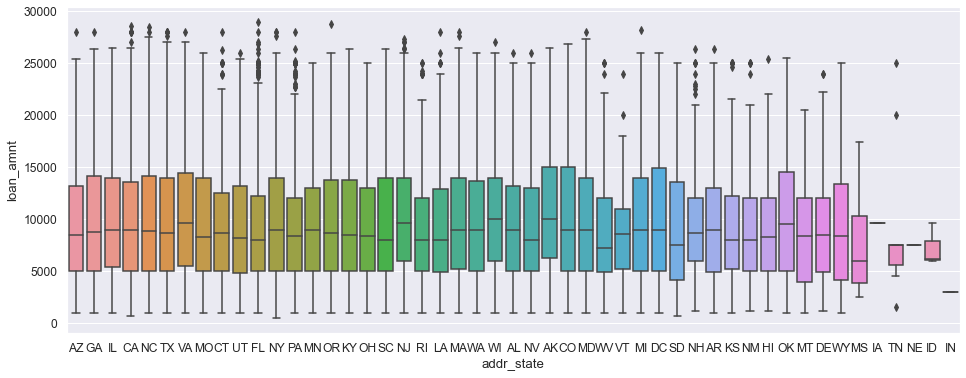

In [1075]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.addr_state)
plot.show()

***
- Highest volume of loans is from CA and purely based on volumes the hoghest Charge Off's are from CA
- Within each state NE and NV has the highest Charge Offs
- NE has very low volume this cannot be considered
- Loan applications from NV will have high risk
- **Inferences**
    - Loan applications from NV (Neveda) have high risk of Charge Offs
    - NE has very high probablity of Charge Offs. Volume too low
    - NV,CA and FL have high percentage of Charge Off's
***

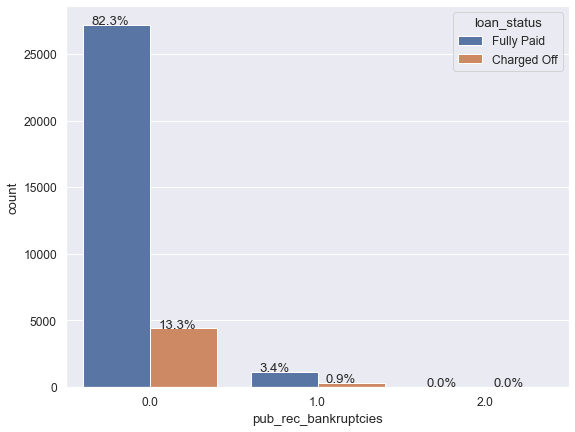

In [1076]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'pub_rec_bankruptcies', 'loan_status')

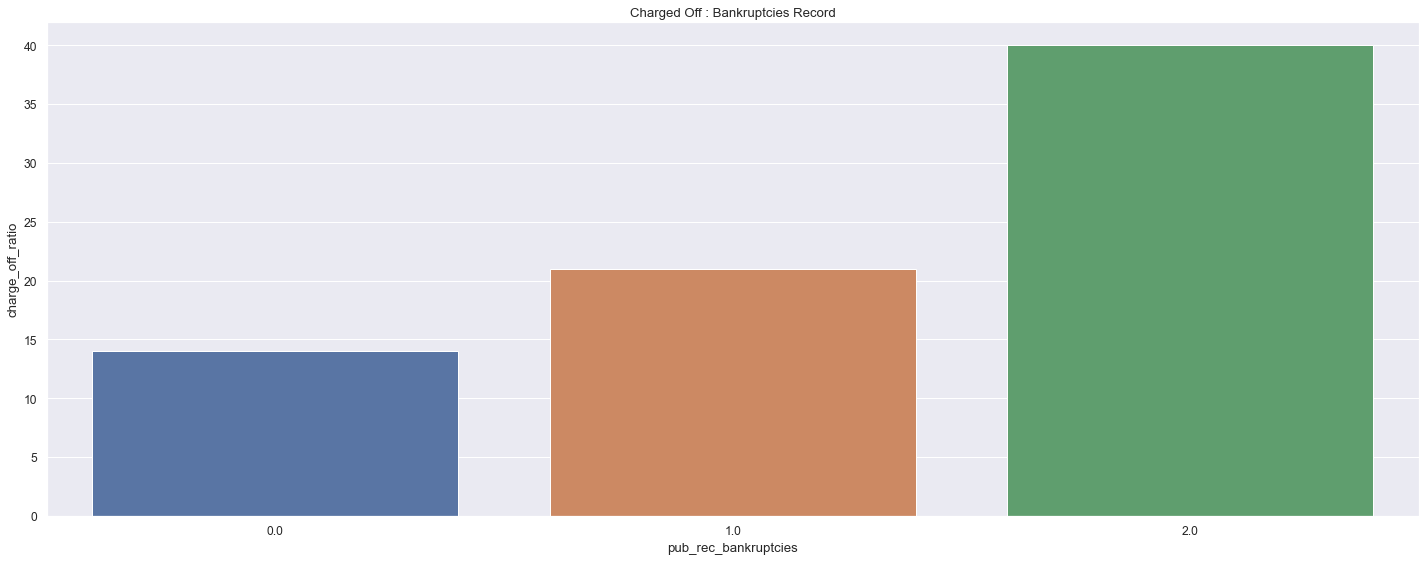

loan_status,pub_rec_bankruptcies,Charged Off,Fully Paid,total,charge_off_ratio
0,0.0,4390,27216,31606,14.0
1,1.0,308,1137,1445,21.0
2,2.0,2,3,5,40.0


In [1077]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'pub_rec_bankruptcies')

***
 - Purely based on volumes the number of charge_offs are in the category of 0 (no bankruptcy record)
 - Looking at ratios within each category, customers having bankruptcy record has high charge_off ratio
 - **Inferences**
    - Customers having bankruptcy record are at high risk of CHarge Offs
    - pub_rec_bankruptcies count 2 has even higher Charge Off ratio
***

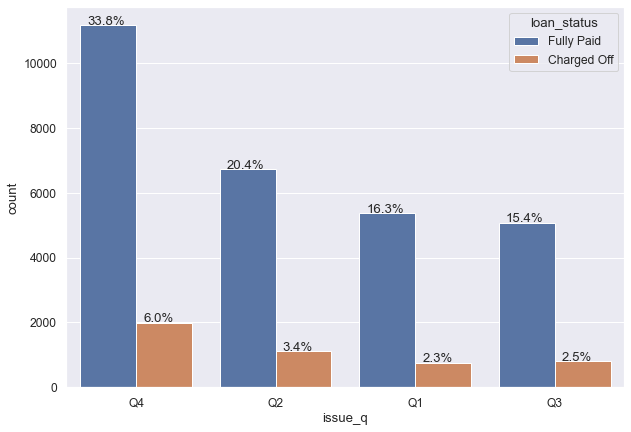

In [1078]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'issue_q', 'loan_status')

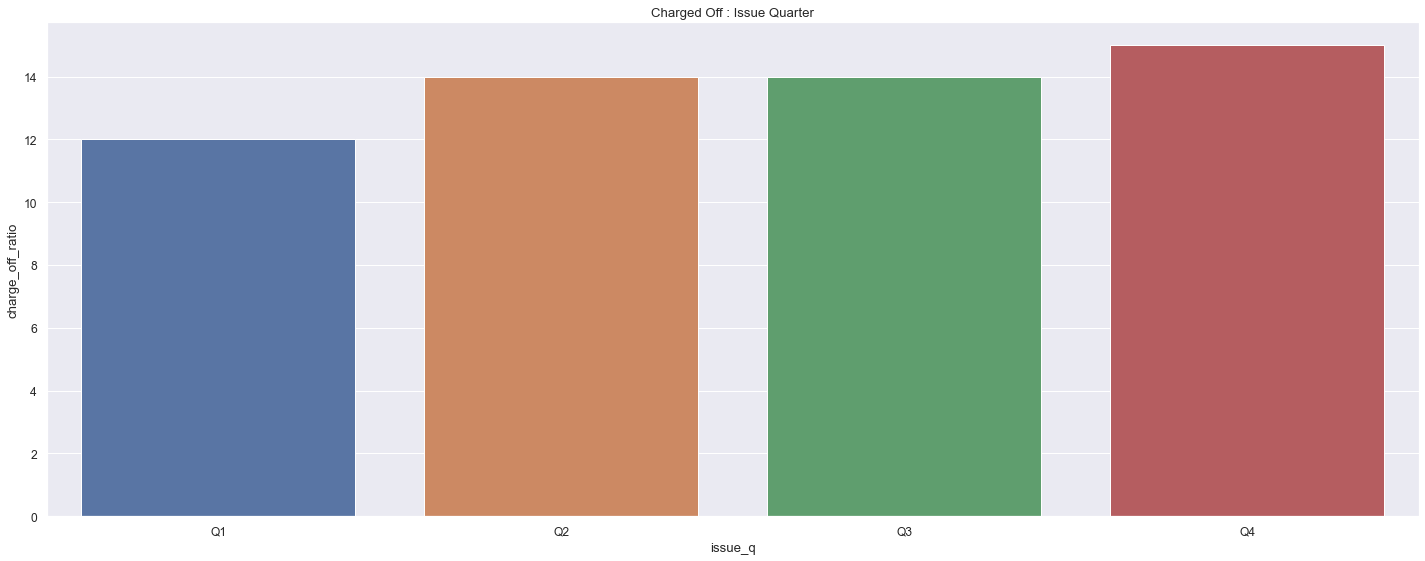

loan_status,issue_q,Charged Off,Fully Paid,total,charge_off_ratio
0,Q1,761,5376,6137,12.0
1,Q2,1124,6728,7852,14.0
2,Q3,818,5078,5896,14.0
3,Q4,1997,11174,13171,15.0


In [1079]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'issue_q')

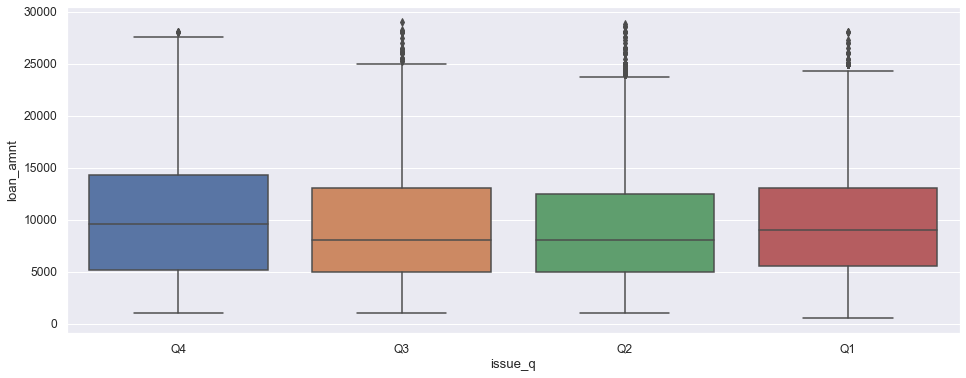

In [1080]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.issue_q)
plot.show()

***
- Quarter 4 has the highest ratio of Charge Offs
- Year has no significant impact as apart from volume increasing year over year, which is impacting charge offs
- 2007 has the maximum Charge Offs. Any current loan running, which started in 2007 may have risk
- **Inferences**
    - Q4 of the year has the highest Charge Off's
    - Charge Off's will increase year over year as the loan volume increases
***

### Annual Income Bucket (annual_inc_b)

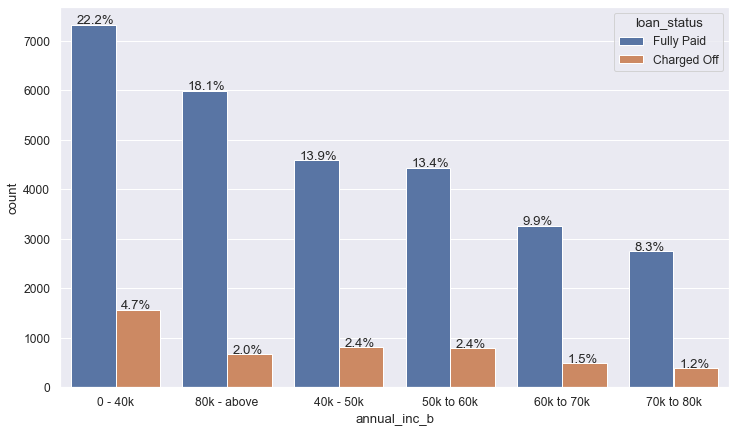

In [1081]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'annual_inc_b', 'loan_status')

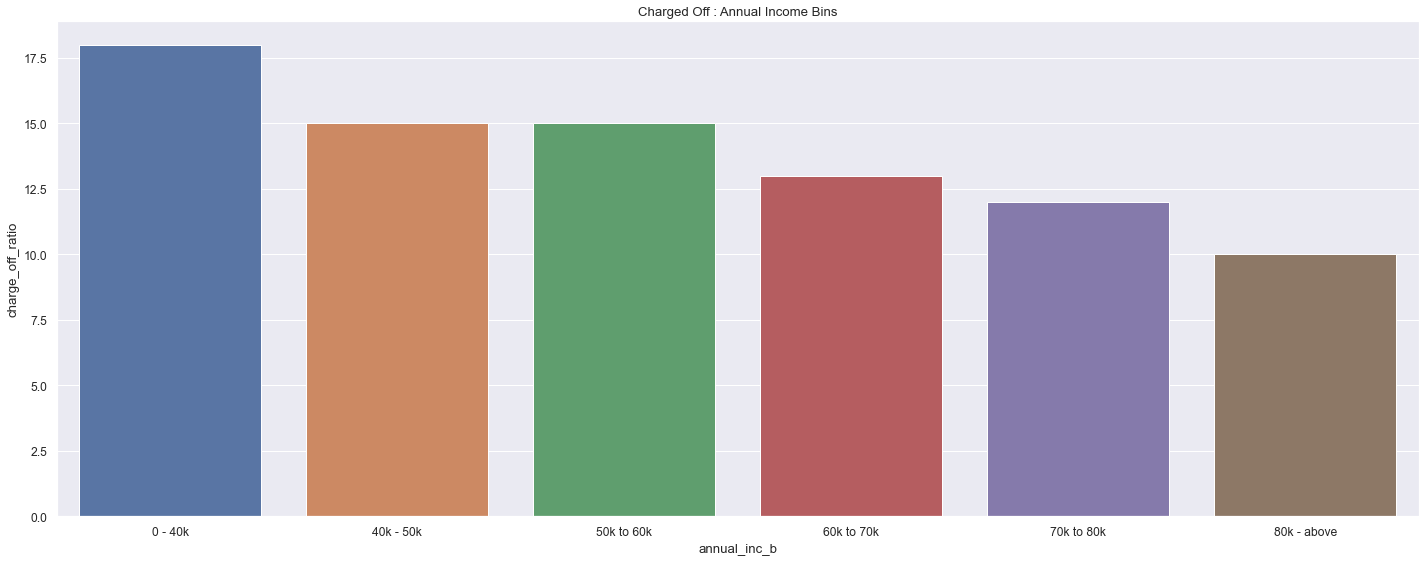

loan_status,annual_inc_b,Charged Off,Fully Paid,total,charge_off_ratio
0,0 - 40k,1570,7326,8896,18.0
1,40k - 50k,807,4593,5400,15.0
2,50k to 60k,788,4435,5223,15.0
3,60k to 70k,486,3261,3747,13.0
4,70k to 80k,385,2749,3134,12.0
5,80k - above,664,5992,6656,10.0


In [1082]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'annual_inc_b')

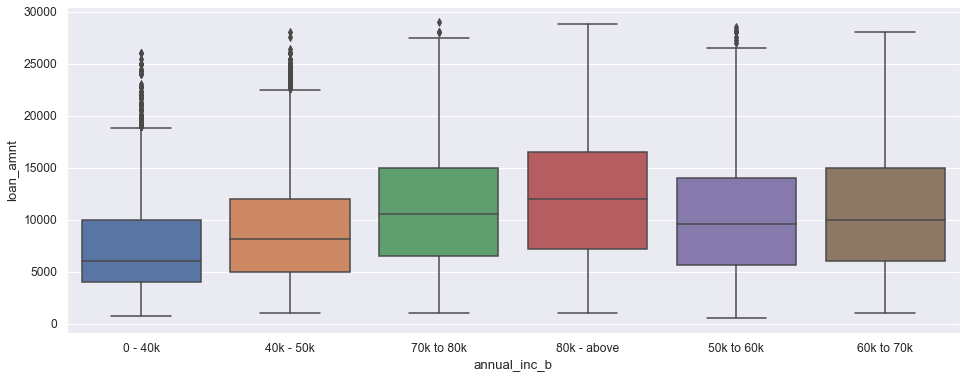

In [1083]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.annual_inc_b)
plot.show()

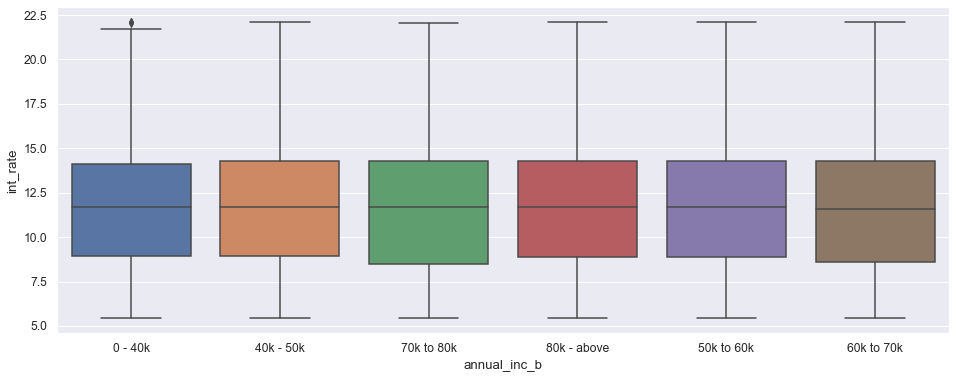

In [1084]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.int_rate,x=loan.annual_inc_b)
plot.show()

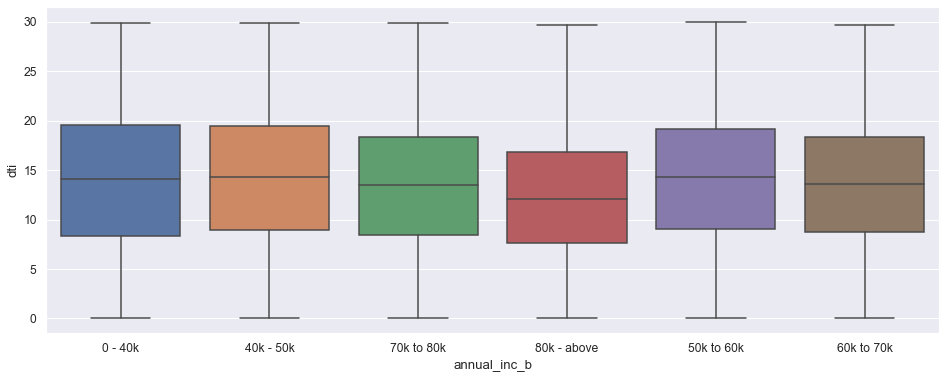

In [1085]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.dti,x=loan.annual_inc_b)
plot.show()

***
- Annual income range of 0-40K has the highest charge offs
- Charge off ratio within the bucket of 0-40K have highest Charge Offs
- **Inferences**
    - Income range of 0-40K have the highest risk
    - Income range 80000+  has less chances of charged off.
    - Increase in annual income charged off proportion decreases. 
***

### Loan Amount Bucket (loan_amnt_b)

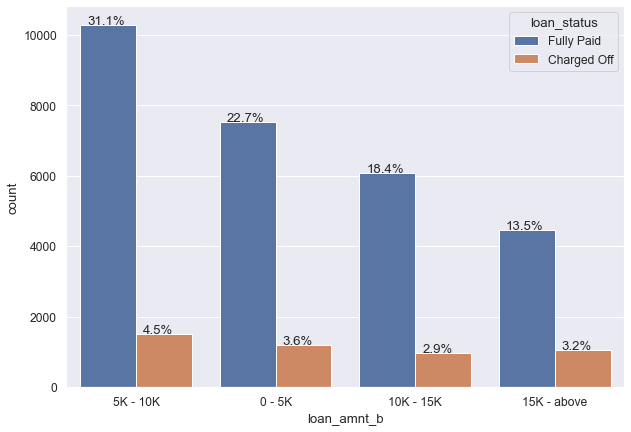

In [1086]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'loan_amnt_b', 'loan_status')

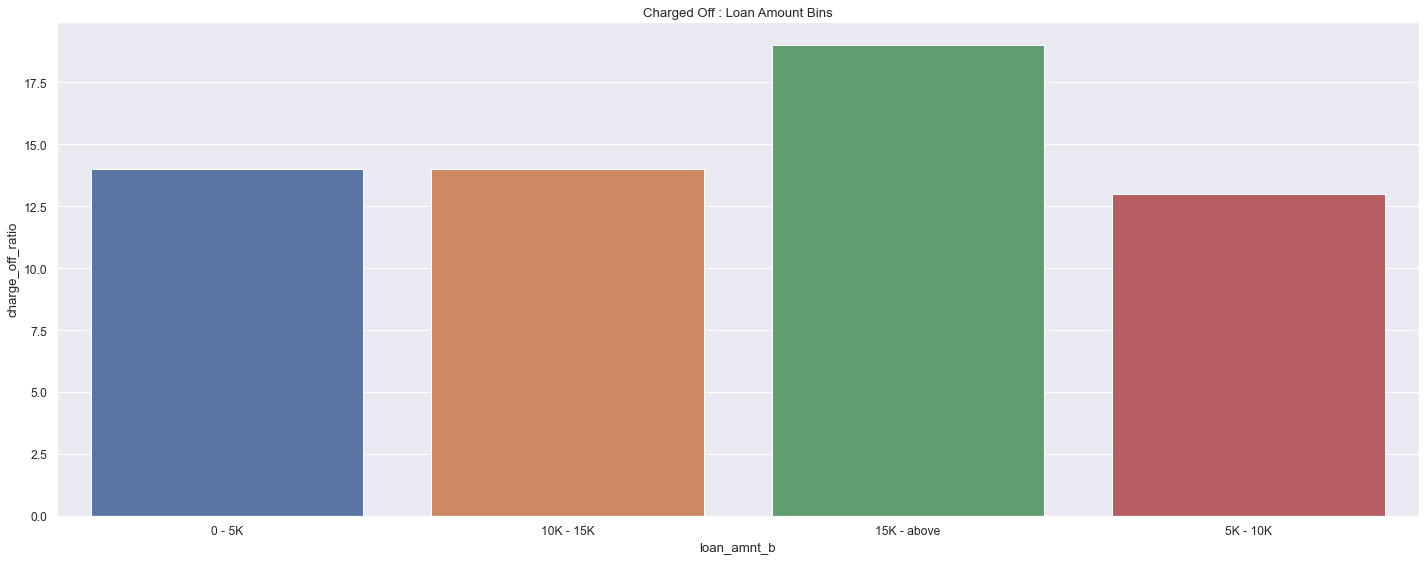

loan_status,loan_amnt_b,Charged Off,Fully Paid,total,charge_off_ratio
0,0 - 5K,1180,7520,8700,14.0
1,10K - 15K,954,6077,7031,14.0
2,15K - above,1063,4466,5529,19.0
3,5K - 10K,1503,10293,11796,13.0


In [1087]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'loan_amnt_b')

***
- Based on volume highest percentage of Charge Offs are in the category of 5K to 10k of loan_ammount
- The Charge Off ratio of all the customer;s within the loan_amount of 15K and above is at the highest CHarge Off risk
- **Inferences**
    - Charge Off risk of loan amount 15K and above is at the highest risk
***

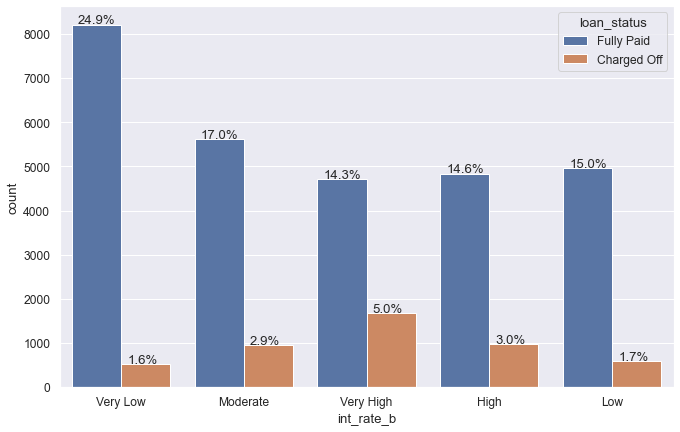

In [1088]:
# Overall ratio of Charge Offs against the total
series_plot(loan, 'int_rate_b', 'loan_status')

### Interest Rate Bucket (int_rate_b)

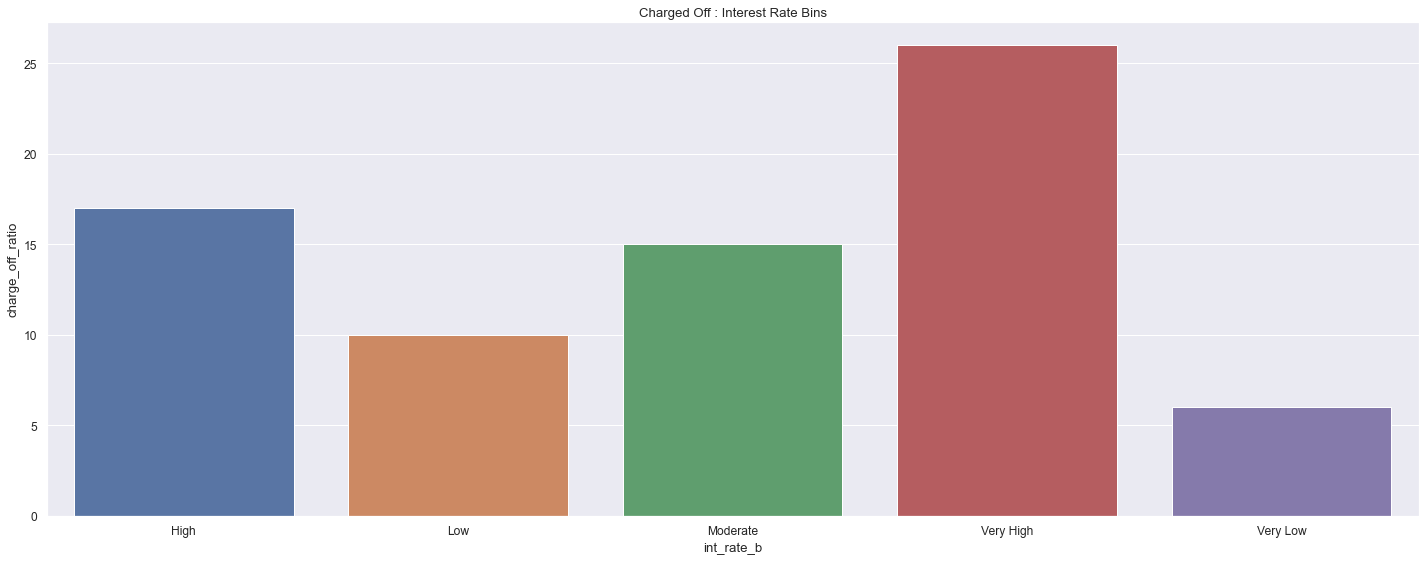

loan_status,int_rate_b,Charged Off,Fully Paid,total,charge_off_ratio
0,High,981,4837,5818,17.0
1,Low,578,4964,5542,10.0
2,Moderate,958,5618,6576,15.0
3,Very High,1665,4721,6386,26.0
4,Very Low,518,8216,8734,6.0


In [1089]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loan, 'int_rate_b')

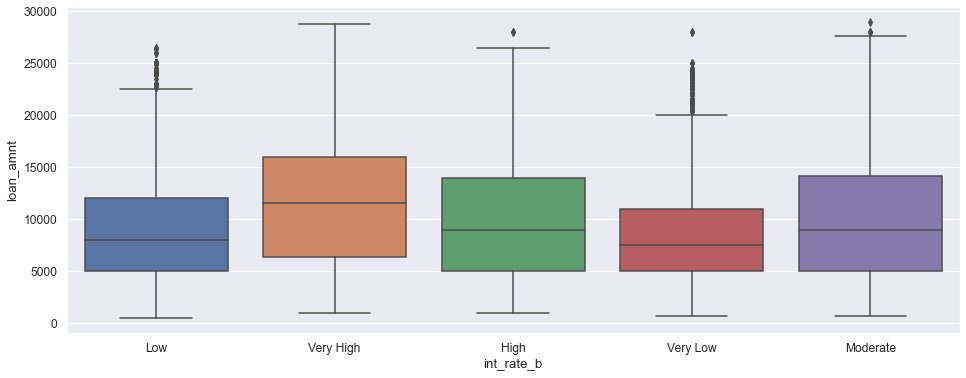

In [1090]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loan.loan_amnt,x=loan.int_rate_b)
plot.show()

***
- Based on volume and based on Charge Off ratio within the category, the Very High interest rates are in risk of Charge Off
- Very High interest rate is 15% and above
***

### Correlation Analysis

In [1091]:
corr_loan = loan

In [1092]:
# Printing column info to analyse missing values, empty values in a column
print(corr_loan.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33056 entries, 0 to 39680
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    33056 non-null  int64         
 1   loan_amnt             33056 non-null  float64       
 2   term                  33056 non-null  int64         
 3   int_rate              33056 non-null  float64       
 4   installment           33056 non-null  float64       
 5   grade                 33056 non-null  object        
 6   emp_length            33056 non-null  float64       
 7   home_ownership        33056 non-null  object        
 8   annual_inc            33056 non-null  float64       
 9   verification_status   33056 non-null  object        
 10  issue_d               33056 non-null  datetime64[ns]
 11  loan_status           33056 non-null  object        
 12  purpose               33056 non-null  object        
 13  zip_code        

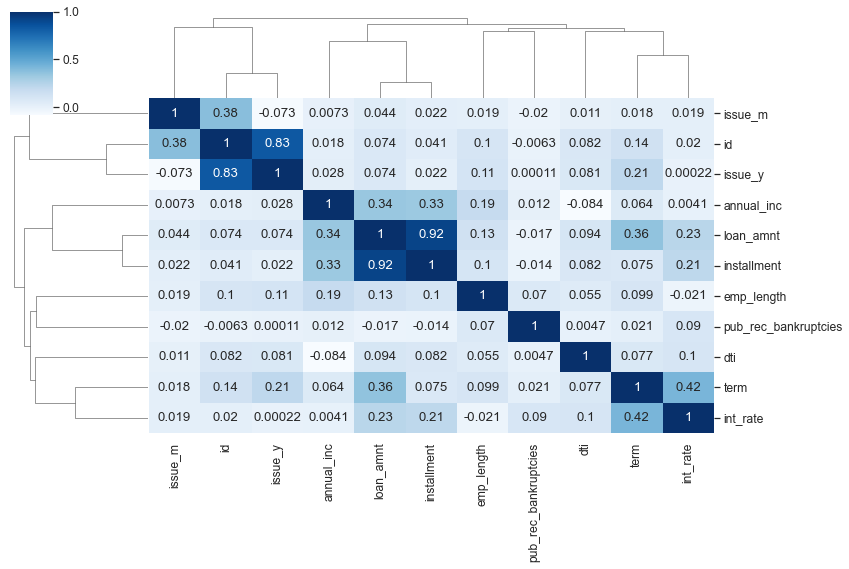

In [1093]:
corr = corr_loan.corr()
sea.set(font_scale=1.1)
sea.clustermap(corr, annot=True, figsize=(12, 8), cmap="Blues")
plot.show()

In [1094]:
# Data-Cleanning
# Dropping redundant fields related to the 'loan_amnt'. They show high correlation in the corr-matrix
# Dropping fields id which do not contribute to analysis
# Dropping fields issue_y and issue_m
drop_columns = ['installment', 'id', 'issue_y', 'issue_m']
corr_loan = corr_loan.drop(columns=drop_columns)

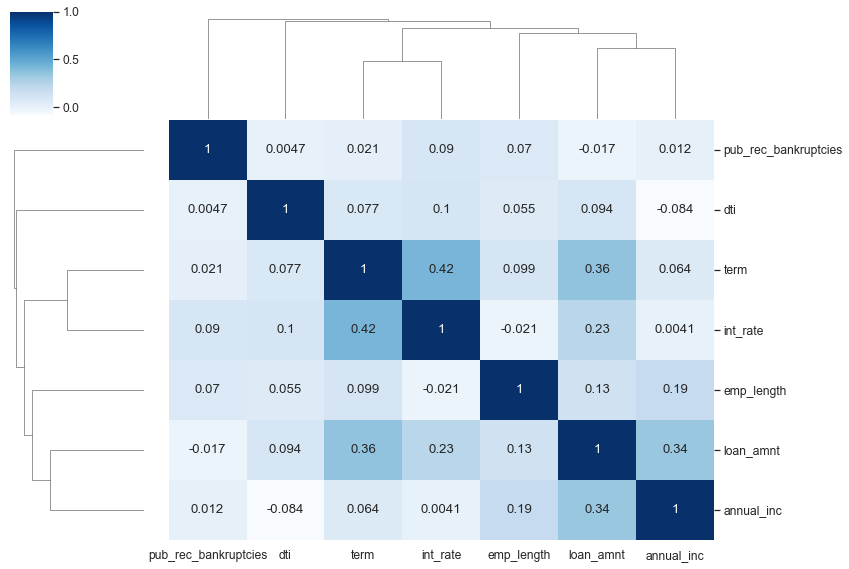

In [1095]:
corr = corr_loan.corr()
sea.set(font_scale=1.1)
sea.clustermap(corr, annot=True, figsize=(12, 8), cmap="Blues")
plot.show()

**Negative Correlation**
- loan_amnt has negative correlation with pub_rec_bankrupticies
- annual income has a negative correlation with dti

**Strong Correlation**
- term has a strong correlation with loan amount
- term has a strong correlation with interest rate
- annual income has a strong correlation with loan_amount

**Weak Correlation**
- pub_rec_bankruptcies has weak correlation with most of the firlds

<AxesSubplot:xlabel='term', ylabel='loan_amnt'>

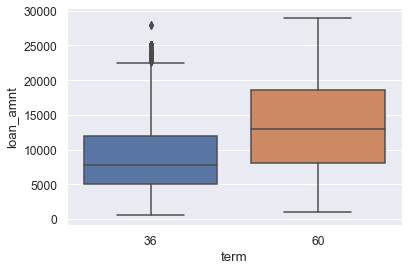

In [1096]:
sea.boxplot(x = 'term', y = 'loan_amnt', data=corr_loan)

<AxesSubplot:xlabel='term', ylabel='int_rate'>

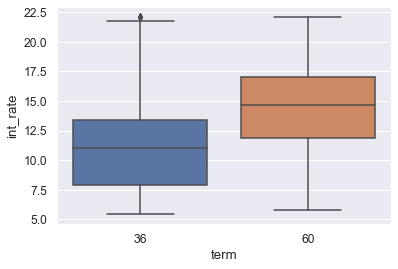

In [1097]:
sea.boxplot(x = 'term', y = 'int_rate', data=corr_loan)

<AxesSubplot:xlabel='term', ylabel='int_rate'>

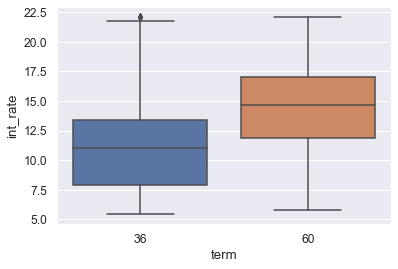

In [1098]:
sea.boxplot(x = 'term', y = 'int_rate', data=corr_loan)

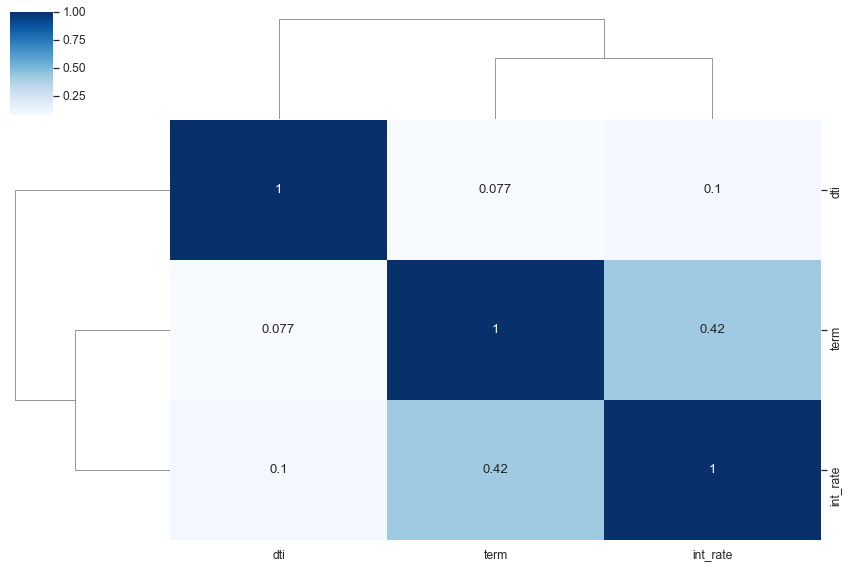

In [1099]:
corr = corr_loan.loc[:, [ 'term', 'int_rate', 'dti']].corr()
sea.set(font_scale=1.1)
sea.clustermap(corr, annot=True, figsize=(12, 8), cmap="Blues")
plot.show()

<Figure size 432x720 with 0 Axes>

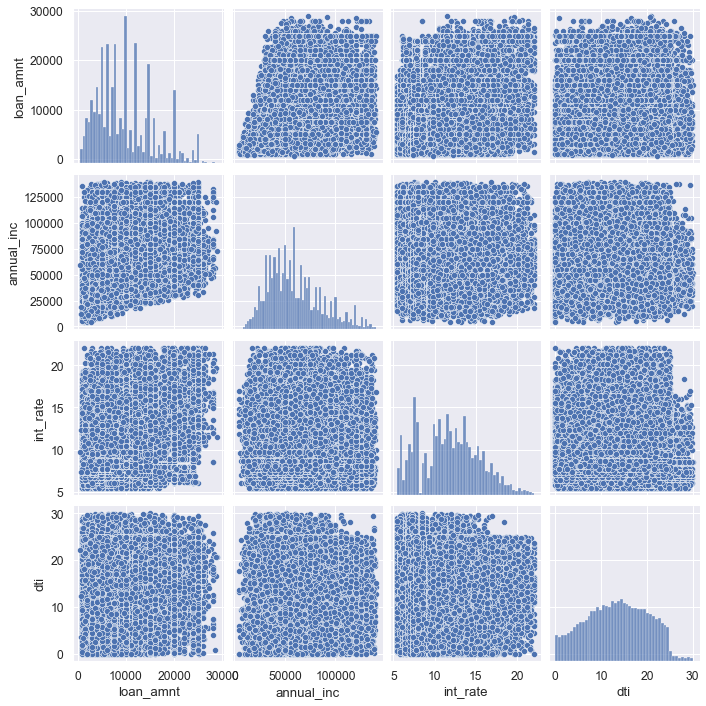

In [1100]:
plot.figure(figsize=(6,10))
sea.pairplot(loan[['loan_amnt', 'annual_inc', 'int_rate', 'dti']])
plot.show()

### Bivariate Analysis Summary

## Summary